<a name="outline"></a>

## Outline

- [Task 1](#task-1): Regression
  - [1.1](#q11) Linear regression
  - [1.2](#q12) Ridge regression
  - [1.3](#q13) Relaxation of Lasso regression
- [Task 2](#task-2): Classification
  - [2.0](#q) Data preparation
  - [2.1](#q21) kNN classifier
  - [2.2](#q22) Random forest 
  - [2.3](#q23) Support vector machine (SVM) 

# 0. Introduction
Regression and classification are two classical machine learning topics with several methods and approaches available.
In this notebook, I explore and compare basic algorithms by applying them on two small/medium size datasets. The _chemistry_ datasets contain numerical variables, whereas in the _tumour_ datasets, the predicted variables are categorical. This latter dataset is imbalanced and thus may requires a more elaborate approach. Regression and classification will also allow us to illustrate the breadth of algorithms available for these tasks as well as some general techniques and considerations of data science.

Throughout this notebook, we work with data points $(x^{(i)}, y^{(i)}),$ where $i = 1, ... N$, also referred to as the training set. The $x^{(i)}s$ can be vectors and are considered the predictors/features, the $y^{(i)}s$ denote the components of the outcome variable. We define a loss function (dependent on the method being used) $L(y, f(x))$, where $f(x)$ denotes the predictor of $y$. The goal is to minimize the mean sample loss $E(L) = \frac{1}{N} \sum_{i=1}^{n}{L(y^{(i)}, f(x^{(i)}))}$, which can be thought of as our approximation of the "true" loss function.

In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
import seaborn as sns

<a name="task-1"></a>
# Task 1: Regression [^](#outline)

Linear regression (and its variants) is a simple method that is able to capture linear relationships in the data. It is a suitable first method when the data is expected to contain linear relationships among the features. We use the _chemistry_samples_ data for training. In order to see whether linear regression is a feasible method for our data, we look at correlation plots of the 11 features. This supports our linearity assumption as a few features show strong correlations with other features (e.g. CIC0 and VFV). 

We choose the feature 'LC50', which measures the toxicity level of the fish, to predict from the remaining freatures using multiple linear regression. Choosing this as the outcome variable is not particularly suggested by the correlation plots, however it is reasonable because of its biological significance: we wish to understand which chemicals influence the toxicity levels of the fish.

We explore the simple version or linear regression, as well as rmodifications with penalty functions: ridge regression and a smoothened version of the lasso.

In [34]:
#read in and prepare data
chem_train = pd.read_csv('chemistry_samples.csv')
chem_test = pd.read_csv('chemistry_test.csv')
chem_y = np.array(chem_train['LC50'])  #  separate outcome variable
chem_X = chem_train.drop('LC50', 1).to_numpy()  #  necessary for the algorithms to work
chem_y_test = np.array(chem_test['LC50'])
chem_X_test = chem_test.drop('LC50', 1).to_numpy()
print(chem_train.shape)
chem_train.head()

(4111, 11)


,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,FV1,VFV,FV2,FV3,LC50
0,3.661280,0.658363,1.602232,1.994272,0.836488,3.153623,15.893033,-27.724370,0.059355,0.756698,5.506249
1,3.936362,1.154287,1.146997,0.904295,2.948308,5.141095,13.590177,-31.821521,-13.408855,1.161298,6.636791
2,0.964144,0.415485,1.481028,2.136585,0.043679,-1.156783,15.989419,-3.699312,2.561525,0.500115,1.563388
3,2.074617,1.417296,0.486216,0.000908,-0.066980,2.610960,7.962046,-16.374439,2.448975,1.481888,6.248432
4,1.448569,0.836892,1.951012,0.028318,-0.039121,1.851095,22.285266,-9.526361,2.870400,0.649234,3.676796


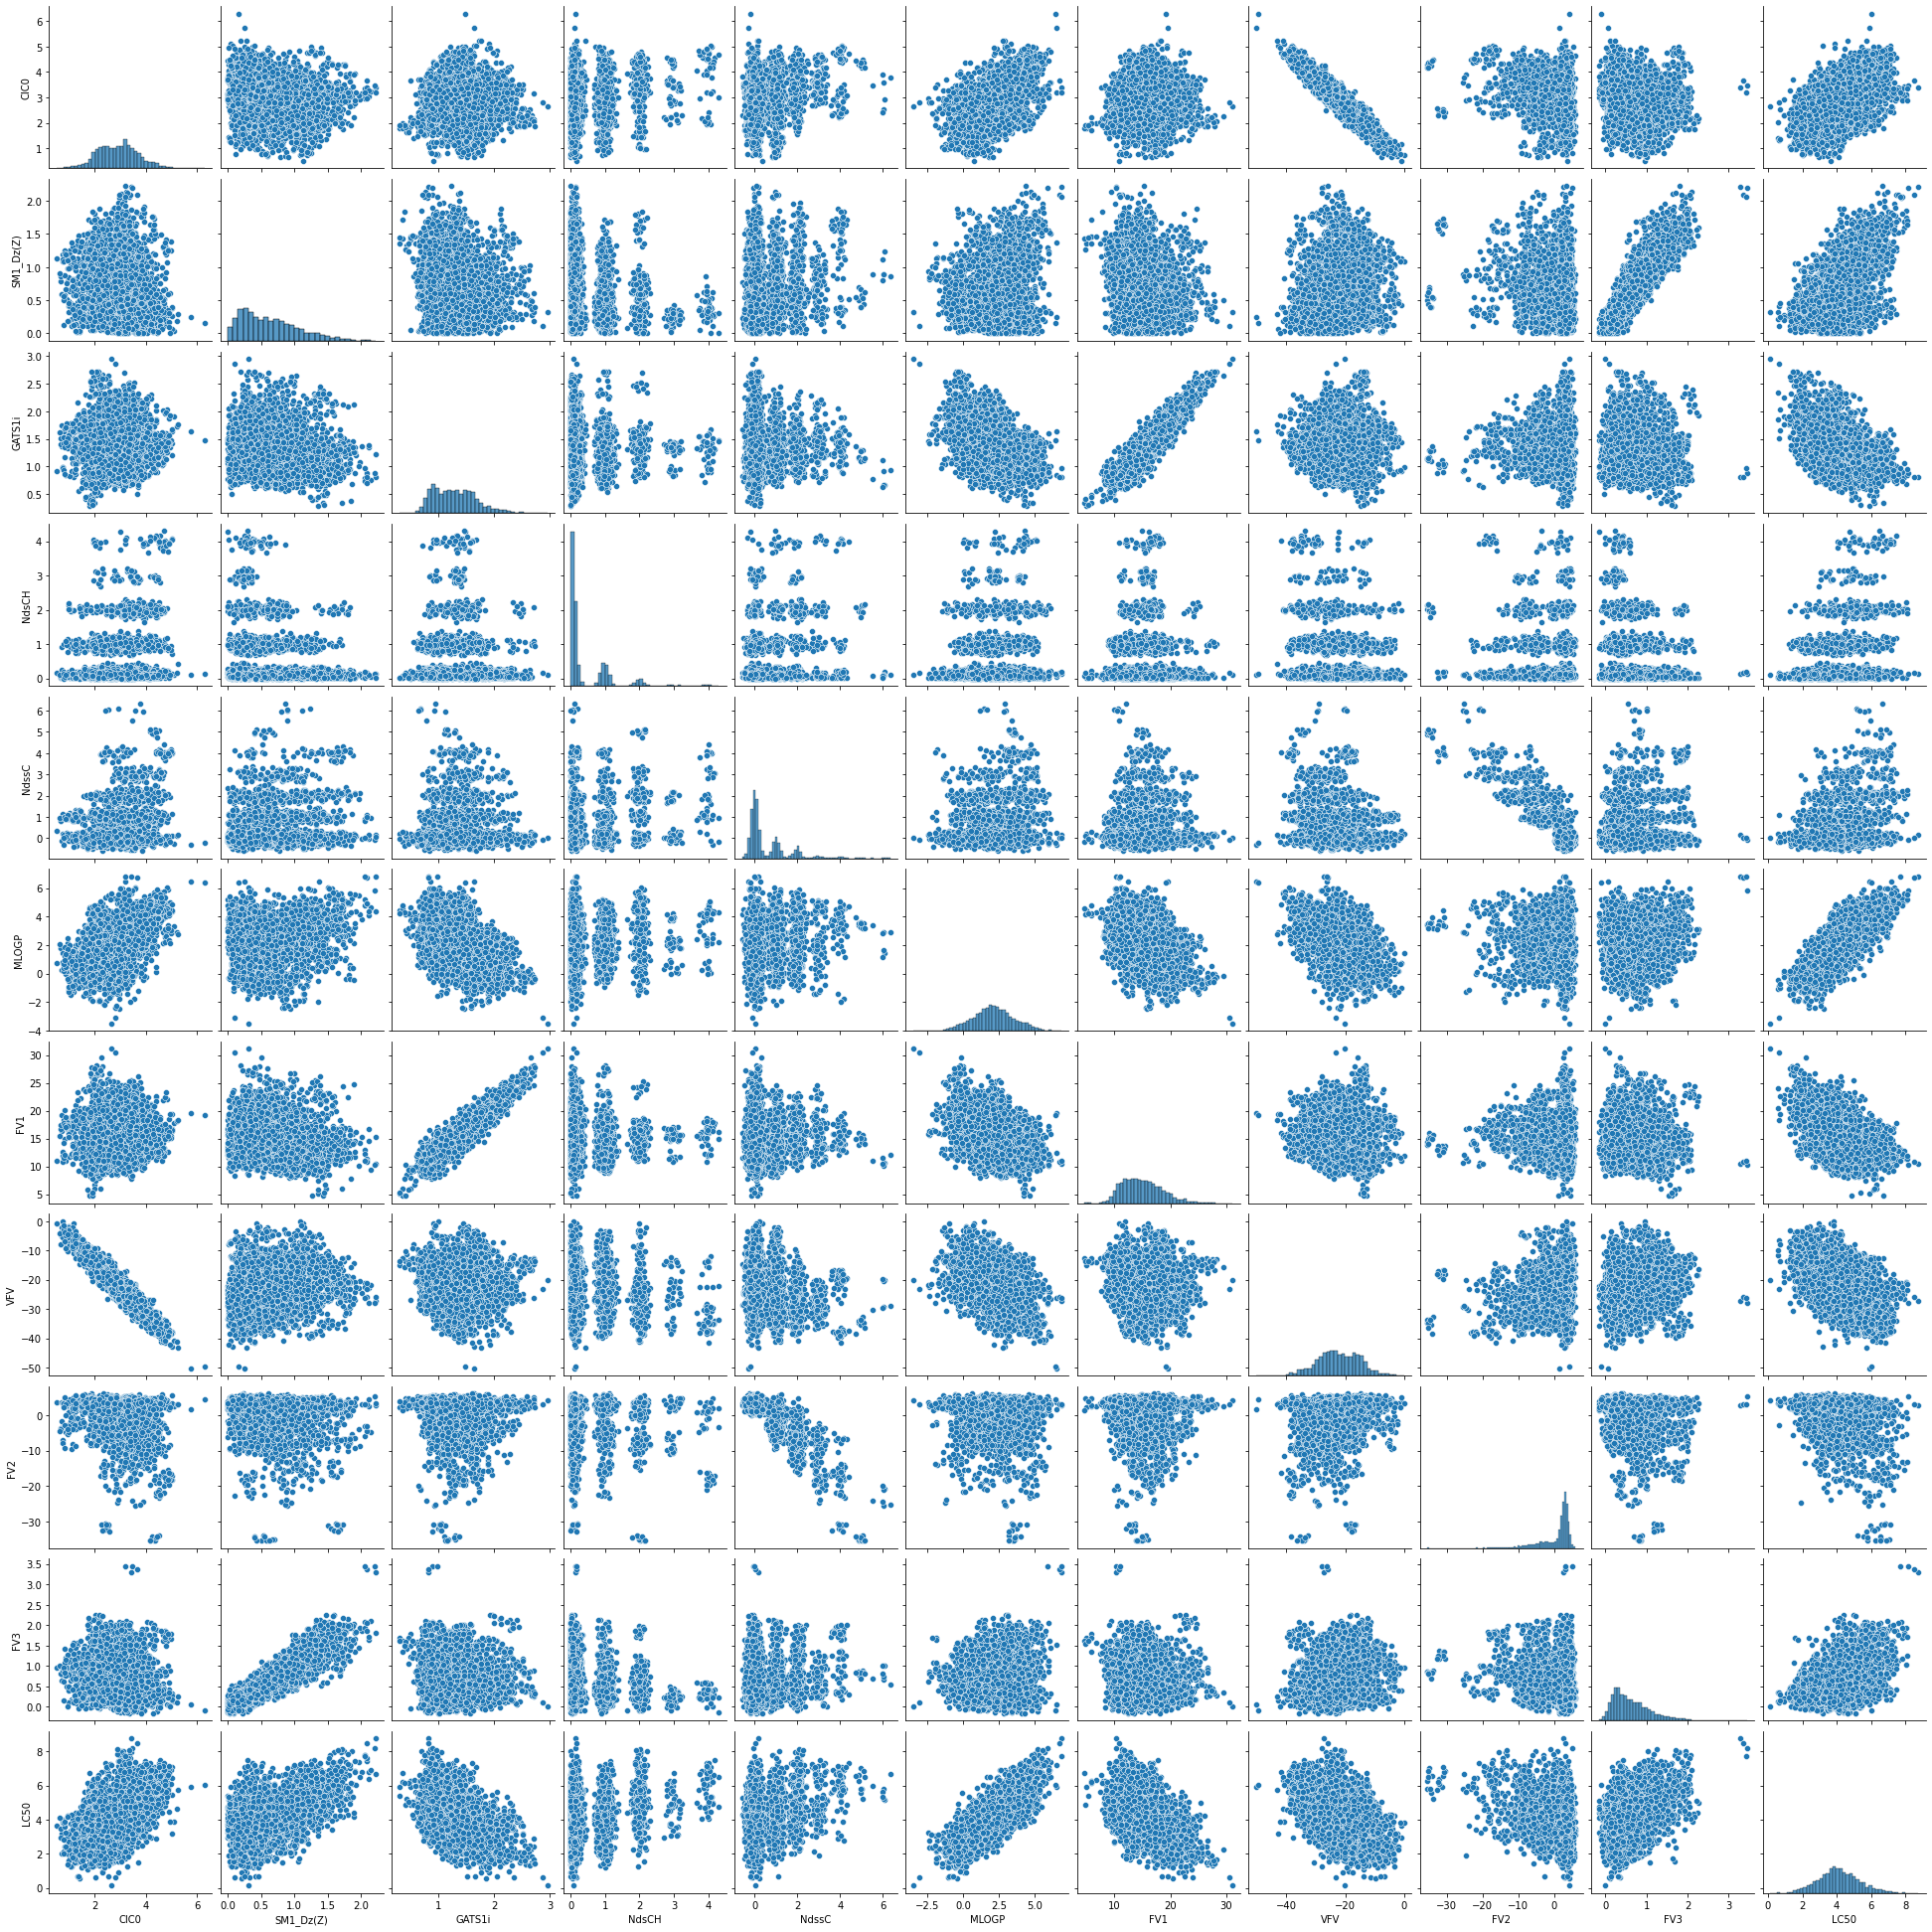

In [3]:
sns.pairplot(chem_train)

<a name="q11"></a>

## 1.1  (Simple) Linear Regression [^](#outline)

Simple linear regression aims to predict $y$ as a linear function of the columns of the data matrix $X$, where the coefficients are given by the vector $\beta$. The assumption is thus $y = X \beta$. The cost function to be minimised is the mean squared error given by
$$ L(y, f_{LR}(\mathbf{x})) = \frac{1}{N} \mathbf{e}^T \mathbf{e}, $$ where $\mathbf{e}$ denotes the error of our model $ \mathbf{e}= y-\hat{y} = y-X \beta$. This is precisely the least-squares problem, and thus an explicit solution for the global minimum is available via differentiating the cost function. The estimates for $\mathbf{\beta}$ and $y$ are
$$\mathbf{\beta^{\star}} = (X^TX)^{-1}Xy, \qquad \hat{y} = X\beta^{\star}.$$

A question to consider is adding an intercept term $\beta_0$ to the to-be-fitted regression coefficients. The intercept can be thought of as an extra degree of freedom when fitting the model, and is a good idea to use unless prior knowledge of the data suggests otherwise. In this case, the data matrix $X$ is augmented with a column of 1-s added before the first column.

In the following, we train a simple linear regression model with intercept. We verify that the fitted intercept is nonzero (thus fitting an intercept improved the model). We also assess the performance of the model with the $R^2$ (coefficient of determination) statistic for both in-sample and out-of sample data (Section 1.1.1) and interpret the results in Section 1.1.2. 

### 1.1.1 Training

In [4]:
N, D = np.array(chem_X).shape
chem_X_aug = np.hstack([np.ones((N,1)), chem_X]) # augmented training inputs of size N x (D+1)
beta_aug = np.zeros((D+1, 1)) # new beta vector of size (D+1) x 1

def max_lik_estimate_aug(X_aug, y):
    """Return the maximum likelihood estimate for the coefficient vector."""
    beta_aug_ml = np.linalg.inv(X_aug.T@X_aug)@X_aug.T@y
    return beta_aug_ml

def predict_with_estimate(X_test, beta):
    """Predict the outcome variable using the training data and the fitted beta coefficients.
    
    X_test: K x D matrix of test inputs
    beta: D x 1 vector of parameters
    returns: prediction of f(X_test); K x 1 vector
    """

    prediction = X_test@beta

    return prediction 

def r_squared(y_estimate, y_true):
    """Calculate the R^2 value for the estimate of y."""  
    y_bar = np.mean(y_true)
    SSR = sum((y_estimate - y_true)**2)
    SST = sum((y_true-y_bar)**2)
    
    return 1 - (SSR/SST)

In [5]:
beta_lin = max_lik_estimate_aug(chem_X_aug, chem_y)

# predict the function values at the test points using the maximum likelihood estimator
ml_prediction = predict_with_estimate(chem_X_aug, beta_lin)

print("Betas: ", beta_lin)
print("In sample R^2: ", r_squared(ml_prediction, chem_y))

Betas:  [ 2.61638041e+00  4.47138333e-02  1.25871884e+00 -3.80092766e-02
  3.63073448e-01  4.66534885e-03  3.90510052e-01 -7.46028629e-02
 -3.57069460e-02 -1.52588258e-02 -1.80315940e-03]
In sample R^2:  0.8718259975718013


### 1.1.2 Interpretation

We can see from Section 1.1.1 that the first component of the fitted $\beta$ vecor is around 2.62, justifying the need for an intercept in the model. We also note that the in-sample and out-of-sample $R^2$ are around 0.86-0.87, with a difference below 0.01. This is a reasonably strong result, and it suggests some degree of a linear relationship between the features and the outcome. The small difference between the values indicates that there is no serious risk of overfitting, which would likely be the case with high in-sample and low out-of-sample $R^2$ values.

The suggested linear relationship can be tested formally by assuming the null hypothesis that, for instance, all the $\beta$ coefficients are 0. There are other hypothesis tests to consider that only test the significance of one or a set of the features - these can be applied when there is some intuition (either a priori or from the data) on which features might be unimportant. A p-value can be obtained using the ANOVA F-test statistic.

Least squares regression, under the gaussianity assumptions, is unbiased, but the estimated parameters may have a large variance. This is given by 
$$E[(\beta - \beta^{\star})(\beta - \beta^{\star})^T] = (X^TX)^{-1}\sigma^2,$$
where $\sigma^2$ is the variance of the noise in the observations, and can be estimated using the sample variance estimator.

This can be due to the matrix $(X^TX)^{-1}$ almost losing full rank. To overcome the linear dependence, one can eliminate predictors that are less significant. In order to search the space for sets of predictors to be eliminated, one can use combinatorial optimization algorithms or shrinkage methods. In the following sections, we consider the latter approach.

We can see from below that the average of the elements of $(X^TX)^{-1}\sigma^2$ has magnitude 1e-5, thus the model does not suffer from high variance. This means that we expect our shrinkage methods to only provide moderate improvement.

In [6]:
N = np.array(chem_X_test).shape[0]
chem_X_test_aug = np.hstack([np.ones((N,1)), chem_X_test]) # augmented training inputs of size N x (D+1)
ml_prediction_out = predict_with_estimate(chem_X_test_aug, beta_lin)
lin_in_r2 = r_squared(ml_prediction, chem_y)
lin_out_r2 = r_squared(ml_prediction_out, chem_y_test)
print("In sample R^2: ", lin_in_r2)
print("Out of sample R^2: ", lin_out_r2)

In sample R^2:  0.8718259975718013
Out of sample R^2:  0.8642933369927284


In [7]:
inv = np.linalg.inv(chem_X_aug.T@chem_X_aug)
var_lin = (1/(4100)*np.sum((ml_prediction-chem_y)**2))*inv
print("Sample variance of prediction sigma^2: ", 1/(4100)*np.sum((ml_prediction-chem_y)**2))
print("Average of variance matrix values: ", np.mean(np.mean(var_lin, 1)))

Sample variance of prediction sigma^2:  0.18701440331056224
Average of variance matrix values:  3.298735620228627e-05


<a name="q12"></a>
## 1.2 Ridge Regression [^](#outline)
Ridge regression is a shrinkage method that sacrifises unbiasedness in the hope of a significant variance reduction.  It transforms the problem of feature selection from a combinatorial optimisation problem to a continuous optimisation one, by keeping the coefficients of the less important features small. This is done by penalizing high values of $\beta$, using the $l_2$ norm.

The loss function is thus
$$L_{\text{RIDGE}}(\beta) = \|y -X\beta\|^2 + \lambda \|\beta\|^2 ,$$
with $\lambda \geq 0,$ a penalty term to be chosen. An explicit solution is available as
$$\mathbf{\beta}_{\text{RIDGE}}^{\star} = (X^TX + \lambda I)^{-1}Xy, \qquad \hat{y} = X\beta_{\text{RIDGE}}^{\star}.$$

The penalty term $\lambda$ is a hyperparameter, thus the model must be optimized by scanning a reasonable range for $\lambda$. We use the Mean Squared Error (MSE) as evaluation metric because it encorporates both the bias and the variance of the estimator. We carry out this optimization step using 5-fold cross-validation, the convential choice for analyzing a small dataset.

In many cases, ridge regression can lead to a better trade-off between the bias and variance. In section 1.1.2, we have seen that our simple linear regression model does not suffer from a particularly large variance, thus we expect the improvement given by ridge regression moderate. 

### 1.2.1 Implementation and cross-validation
Below we implement ridge regression with intercept, and 5-fold cross-validation to find the optimal value for the penalty hyperparameter $\lambda$. Because of version control reasons, the function MSE_score will be reused in section 1.3, hence it contains a 'huber' method.

In [8]:
def ridge_estimate(X, y, penalty):
    """Return the ridge regression estimate of the boefficient vector beta.
    
    X: N x D matrix of training inputs
    y: N x 1 vector of training targets/observations
    returns: maximum likelihood parameters (D x 1)
    """
    N, D = X.shape
    X_aug = np.hstack([np.ones((N,1)), X]) # augmented training inputs of size N x (D+1)
    N_aug, D_aug = X_aug.shape
    I = np.identity(D_aug)
    I[-1,-1] = 0
    beta_ridge = np.linalg.solve(X_aug.T @ X_aug + penalty * I, X_aug.T @ y) ## <-- SOLUTION
    return beta_ridge

def MSE_val_fn(y_pred, y_val):
    """Compute the MSE of the prediction and the true value."""
    #assert y_pred.shape[0] == y_val.shape[0]
    y_val = y_val.reshape(-1,1)
    y_pred = y_pred.reshape(-1, 1)
    MSE = np.sum((y_pred - y_val)**2) / len(y_val)

    return MSE

def MSE_score(X_train, y_train, X_val, y_val, penalty, method):
    """Return the MSE corresponding to a training and validation dataset."""
    
    if method == 'ridge':
        beta = ridge_estimate(X_train, y_train, penalty=penalty)
   
    elif method == 'huber':
        beta = minimize_ls_huber(X_train, y_train, lambd=penalty, 
                                 n_iters=200000, step_size=1e-3)
    
    X_val_aug = np.hstack([np.ones((X_val.shape[0],1)), X_val])
    X_train_aug = np.hstack([np.ones((X_train.shape[0],1)), X_train])
    
    y_pred_train = predict_with_estimate(X_train_aug, beta=beta)
    y_pred_val = predict_with_estimate(X_val_aug, beta=beta)

    return MSE_val_fn(y_pred_train, y_train), MSE_val_fn(y_pred_val, y_val)

def cross_validation_MSE(X_train, y_train, folds, penalty, method):
    """"Compute the mean MSE for all folds."""
    MSE_list_train = []  # record MSE values for both training and validation folds
    MSE_list_val = []

    for i in range(len(folds)):  # separate data according to folds indices
        val_indexes = folds[i]
        train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))
    
        X_train_i = X_train[train_indexes, :]
        y_train_i = y_train[train_indexes]

        X_val_i = X_train[val_indexes, :]
        y_val_i = y_train[val_indexes]

        tr, vl = MSE_score(X_train_i, y_train_i, X_val_i, y_val_i, 
                           penalty=penalty, method=method)
        MSE_list_train.append(tr)
        MSE_list_val.append(vl)

    return np.mean(MSE_list_train), np.mean(MSE_list_val)

def choose_best_penalty(X_train, y_train, folds, penalty_range, method):
    """Find the optimal value of the penalty hyperparameter."""
    penalty_MSE_train = np.zeros((len(penalty_range),))
    penalty_MSE_val = np.zeros((len(penalty_range),))
  
    for i, p in enumerate(tqdm(penalty_range)):
        
        tr, vl = cross_validation_MSE(X_train, y_train, folds, 
                                      penalty=p,method=method)
        penalty_MSE_train[i] = tr
        penalty_MSE_val[i] = vl       

    best_penalty_train = np.argmin(penalty_MSE_train)
    best_penalty_val = np.argmin(penalty_MSE_val)
    return [penalty_range[best_penalty_val], penalty_MSE_train, penalty_MSE_val]

In [9]:
#sanity check: lambd = 0 should give same prediction as part 1.1.1
beta_ridge_aug = ridge_estimate(chem_X, chem_y, penalty=0)
ml_prediction_ridge_out = predict_with_estimate(chem_X_test_aug, beta_ridge_aug)
#print(Ridge_MSE)
print(f"Prediction of test data by LS: {ml_prediction_out}")
print(f"Prediction of test data by Ridge: {ml_prediction_ridge_out}")

Prediction of test data by LS: [2.4953788  5.65988436 3.74511693 ... 4.30643685 4.45504931 2.40315046]
Prediction of test data by Ridge: [2.4953788  5.65988436 3.74511693 ... 4.30643685 4.45504931 2.40315046]


In [10]:
folds_indices = np.array_split(np.arange(len(chem_y)), 5)  # create folds
ridge_penalty_range = np.linspace(0, 0.15, 1000)
ridge_best_penalty, ridge_MSE_train_vals, ridge_MSE_val_vals = choose_best_penalty(
    X_train = chem_X, y_train = chem_y, folds = folds_indices, 
    penalty_range = ridge_penalty_range, method = 'ridge')

ridge_best_MSE_train, ridge_best_MSE_val = cross_validation_MSE(
    X_train = chem_X, y_train = chem_y, folds = folds_indices,
    penalty = ridge_best_penalty, method = 'ridge')
print(f"best penalty = {ridge_best_penalty}")
print(f"best MSE on validation folds = {ridge_best_MSE_val}")

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 131.77it/s]

best penalty = 0.06186186186186186
best MSE on validation folds = 0.18795064410825138


Text(0.5, 1, 'The average mean squared error for training and validation folds against penalty $\\lambda$')

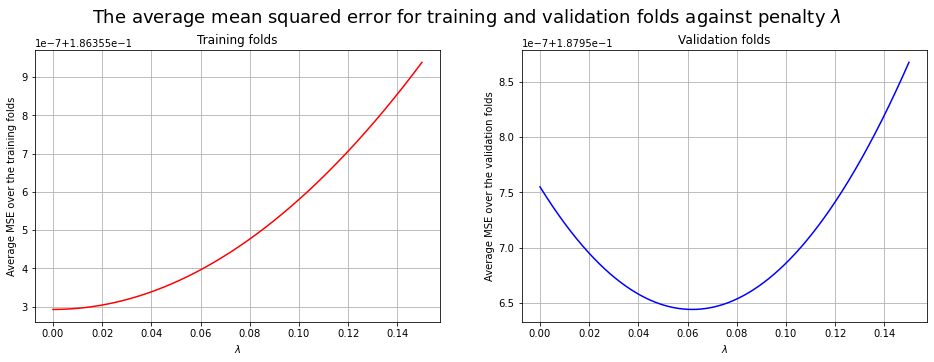

In [11]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(ridge_penalty_range, ridge_MSE_train_vals, color = "r")
plt.xlabel("$\lambda$")
plt.ylabel("Average MSE over the training folds")
plt.title("Training folds")
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(ridge_penalty_range, ridge_MSE_val_vals, color = "b")
plt.xlabel("$\lambda$")
plt.ylabel("Average MSE over the validation folds")
plt.title("Validation folds")
plt.grid()
plt.suptitle("The average mean squared error for training "
             "and validation folds against penalty $\lambda$", fontsize=18, y=1)

The optimal value of the hyperparameter $\lambda$ within the scanned interval $[0, 0.15]$ is $\lambda \approx 0.062$. Initially, a larger interval was scanned, which showed that the global minimum lies in this interval. This value is has a reasonable magnitude, given the fact that we are expecting ridge regression to only moderately improve the results of linear regression.

Comparing the above plots, we can see that increasing the hyperparameter $\lambda$ increases the MSE for the training folds. On the other hand, for the validation folds, the global minimum of the MSE is acheved at a positive value of  $\lambda$. For $\lambda=0$, the MSE is only (nonzero) component of the variance. As we increase $\lambda$, the bias increases while the variance decreases towards 0. The optimal balance can be found at $\lambda \approx 0.062$.

### 1.2.2 Evaluation
We now compute the $R^2$ values for our ridge regression estimates. We then compare the model to linear regression.

In [13]:
X_aug = np.hstack([np.ones((chem_X.shape[0],1)), chem_X])
beta_ridge_aug = ridge_estimate(chem_X, chem_y, penalty=ridge_best_penalty)
ridge_y_pred = predict_with_estimate(X_test = X_aug, beta = beta_ridge_aug)
ridge_in_r2 = r_squared(ridge_y_pred, chem_y)

print("In-sample R^2: ", r_squared(ridge_y_pred, chem_y))

X_aug_test = np.hstack([np.ones((chem_X_test.shape[0],1)), chem_X_test])
y_pred_test = predict_with_estimate(X_test = X_aug_test, beta = beta_ridge_aug)
ridge_out_r2 = r_squared(y_pred_test, chem_y_test)

print("Out-of-sample R^2: ", r_squared(y_pred_test, chem_y_test))

In-sample R^2:  0.8718259491456204
Out-of-sample R^2:  0.8642962573199278


In [14]:
lin_r2 = np.concatenate((np.array([lin_in_r2, lin_out_r2]), np.round(beta_lin, 4)))
ridge_r2 = np.concatenate((np.array([ridge_in_r2, ridge_out_r2]), np.round(beta_ridge_aug, 4)))

ls_ridge_df = pd.DataFrame(np.array([lin_r2, ridge_r2]), 
                           columns=np.concatenate((np.array(["In-sample $R^2$", "Out-of-sample $R^2$"]), 
                                                            np.array([f"beta_{i}" for i in range(len(beta_ridge_aug))]))),
                           index = np.array(["Linear Regression", "Ridge Regression"]))
ls_ridge_df

,In-sample $R^2$,Out-of-sample $R^2$,beta_0,beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,beta_10
Linear Regression,0.871826,0.864293,2.6164,0.0447,1.2587,-0.0380,0.3631,0.0047,0.3905,-0.0746,-0.0357,-0.0153,-0.0018
Ridge Regression,0.871826,0.864296,2.6147,0.0451,1.2584,-0.0384,0.3631,0.0047,0.3906,-0.0745,-0.0357,-0.0152,-0.0014


From the table above, we can see that the obtained $R^2$ for linear and ridge regression don't vary much. The estimates of the $\beta$ coefficients are also close to each other (due to the small $\lambda$ compared to the data values), with some values pushed towards 0. Linear regression has a slightly higher in-sample $R^2$, whereas ridge, with the optimal hyperparameter, has a slightly higher out-of-sample $R^2$. An interpretation could be that the extra 'freedom' in ridge regression allows for a more generalizable model.

The advantage of ridge regression over linear regression is its ability to control the variance. This is done via introducing the penalty as a constraint to the model. Since the MSE is quadratic in the variance and linear in the bias, this is an important strength. In our case, the small value of the optimal lambda shows that ridge regression to only moderately improved the results of linear regression. This makes sense, as linear regression did not suffer from a large variance in our case.

In summary, by introducing the penalty hyperparameter $\lambda$, we allowed the bias to potentially increase while decreasing the variance. Although these quantities cannot be theoretically determined, below we report the sample variance of the estimators as a check of this. We see that the average of the elements of the variance matrix has decreased, but only by a little.

In [15]:
ridge_inv = np.linalg.inv(chem_X_aug.T@chem_X_aug + ridge_best_penalty*np.identity(chem_X_aug.shape[1]))
ridge_sigma_sq = (1/(4100)*np.sum((ridge_y_pred-chem_y)**2))
var_ridge = ridge_sigma_sq*ridge_inv

print("Average of least squares variance matrix values: ", np.mean(np.mean(var_lin, 1)))
print("Average of ridge variance matrix values: ", np.mean(np.mean(var_ridge, 1)))

Average of least squares variance matrix values:  3.298735620228627e-05
Average of ridge variance matrix values:  3.296795674405401e-05


<a name="q13"></a>

## 1.3 Relaxation of Lasso regression[^](#outline)
Lasso regression is a further shrinkage method that enforces sparsity of the descriptors. The penalty in this case is based on the $l_1$ norm. Because of the 'shape' of this function, the LASSO version is closer to a direct selection of parameters than ridge, as it pushes the optimal solution closer to the axes. LASSO doesn't have a theoretical solution, and $l_1$ is not differentiable. We consider a relaxation of the penalty function to differentiable huber-functions, so that we can optimize the cost function via gradient descent.

The cost function becomes
$$L_{\text{LASSO}}(\beta)=\|y -X\beta\|^2 + \lambda \sum_{i=1}^n{L_c(\beta_i)},$$
there $L_c$, the huber functions are defined as
$$L_c(\beta)= 
\begin{cases}
    \frac{1}{2} \beta^2& \text{for } | \beta |\leq c\\
    c(| \beta |-\frac{1}{2}c)              & \text{otherwise.}
\end{cases}$$

The Huber function is a combination of the $l_1$ and $l_2$ norms, using the latter for relatively small and the former for relatively large errors. It is convex, and combines the strengths of the two penalty functions ($l_1$: better relaxation of the 0-pseudonorm, $l_2:$ easier to optimise). 

This version of the LASSO can be solved by gradient descent. We explore this in the coming sections.


### 1.3.1 Implementation
In this section, we implement the huber function and the modified LASSO regression. In order to stay consistent, we check that the huber functions are indeed convex, and that for $\lambda = 0,$ we converge to the MSE obtained by linear regression.

Text(0.5, 1, 'The huber loss function')

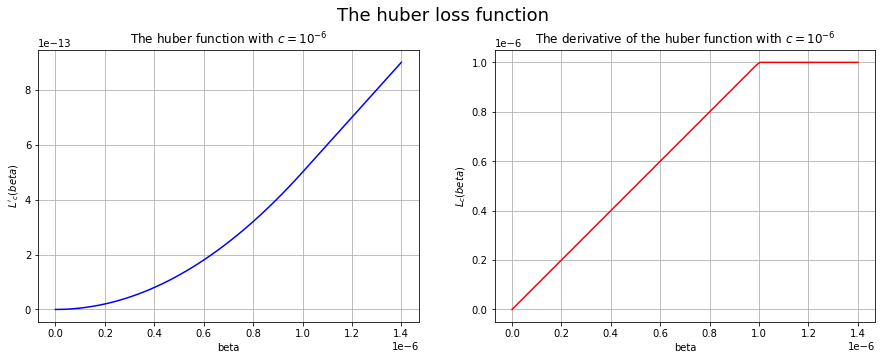

In [21]:
def huber(beta, c=1e-6):
    """Return the value of the huber function at beta."""
    if abs(beta) <= c:
        return (1/2) * beta**2
    else:
        return c*(abs(beta) - c/2)

def grad_huber(beta, c=1e-6):
    """Return the gradient of the huber function at beta."""
    if abs(beta) <= c:
        return beta
    else:
        return c * np.sign(beta)
vhuber = np.vectorize(huber)
vgrad_huber = np.vectorize(grad_huber)

x = np.linspace(0, 0.0000014, 100)
plt.figure(figsize=(15, 5))
plt.subplot(1,2, 1)
plt.plot(x, np.array([huber(i) for i in x]), color="b")
plt.xlabel("beta")
plt.ylabel("$L'_c(beta)$")
plt.title("The huber function with $c=10^{-6}$")
plt.grid()
plt.subplot(1,2, 2)
plt.plot(x, np.array([grad_huber(i) for i in x]), color="r")
plt.xlabel("beta")
plt.ylabel("$L_c(beta)$")
plt.title("The derivative of the huber function with $c=10^{-6}$")
plt.grid()
plt.suptitle("The huber loss function", fontsize=18, y=1)

In [22]:
def minimize_ls_huber(X, y, lambd, n_iters=10000, step_size=2e-2, monitor = False):
    """Find the optimal value of beta with gradient descent."""
    n, p = X.shape
    y = np.array(y).reshape(-1, 1)
    X_aug = np.hstack([np.ones((n,1)), X])  # fit intercept
    XX = X_aug.T @ X_aug / n
    Xy = X_aug.T @ y / n

    beta_aug = np.zeros(shape=(p + 1, 1))
    
    for i in range(n_iters):    # gradient descent
        grad_huber = vgrad_huber(np.vstack([[0], beta_aug[1:]]), c=1e-3)
        grad_huber[0] = 0
        grad = -2*(Xy - (XX @ beta_aug)) + lambd * grad_huber
        assert grad.shape == beta_aug.shape
        beta_aug = beta_aug - step_size * grad / np.linalg.norm(grad)   # gradient descent update
        
        if monitor:
            # can monitor the change in loss
            L = sum((np.array(y) - (X_aug @ beta_aug))**2) + lambd * sum([huber(b, c=1e-3) for b in beta_aug])
            print("New loss:", L)
      
    return beta_aug

### 1.3.2 Tuning lambda via 5-fold cross-validation
We can see that by setting $\lambda=0$, the obtained MSE is close to the one supplied by linear regression. In this and the subsequent chunks, we have worked with 10000 iterations and a learning rate of 2e-2. The learning rate (the step_size variable) was chosen to be high in order to mitigate the computational time of the algorithm. This has the risk of oscillatory behaviour, which was indeed the result.

In [23]:
MSE_score(chem_X, chem_y, chem_X, chem_y, penalty = 0, method = "huber")[1]

0.18670798341523553

In [56]:
lasso_penalty_range = np.linspace(0, 4, 40)
lasso_best_penalty, lasso_MSE_train_vals, lasso_MSE_val_vals = choose_best_penalty(
    X_train = chem_X, y_train = chem_y, folds = folds_indices, 
    penalty_range = lasso_penalty_range, method = "huber")

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [41:00<00:00, 61.51s/it]


In [57]:
lasso_best_MSE_train, lasso_best_MSE_val = cross_validation_MSE(X_train = chem_X, 
                                                                y_train = chem_y, 
                                                                folds = folds_indices, 
                                                                penalty = lasso_best_penalty,
                                                                method = "huber")
print(f"best penalty = {lasso_best_penalty}")
print(f"best MSE on validation folds = {lasso_best_MSE_val}")

best penalty = 2.1538461538461537
best MSE on validation folds = 0.18794253415946208


Text(0.5, 1, 'The average mean squared error for training and validation folds against penalty $\\lambda$')

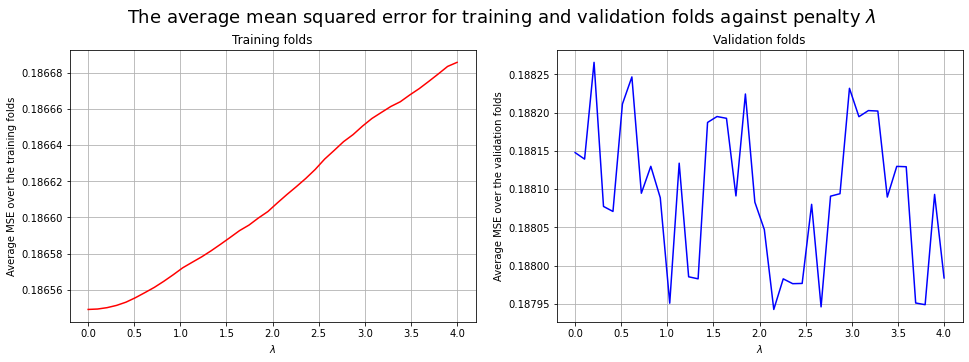

In [58]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(lasso_penalty_range, lasso_MSE_train_vals, color = "r")
plt.xlabel("$\lambda$")
plt.ylabel("Average MSE over the training folds")
plt.title("Training folds")
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(lasso_penalty_range, lasso_MSE_val_vals, color = "b")
plt.xlabel("$\lambda$")
plt.ylabel("Average MSE over the validation folds")
plt.title("Validation folds")
plt.grid()
plt.suptitle("The average mean squared error for training "
             "and validation folds against penalty $\lambda$",
             fontsize=18, y=1)

In [59]:
N = np.array(chem_X).shape[0]
chem_X_aug = np.hstack([np.ones((N,1)), chem_X])
# within minimise_ls_huber, input matrices get augmented, hence no need to augment before
beta_lasso = minimize_ls_huber(X = chem_X, y = chem_y, lambd = lasso_best_penalty, n_iters=2000000, step_size=1e-4)[:,0]
lasso_y_pred = predict_with_estimate(X_test = chem_X_aug, beta = beta_lasso)
lasso_in_r2 = r_squared(lasso_y_pred, chem_y)
print("In-sample R^2: ", lasso_in_r2)

N = np.array(chem_X_test).shape[0]
chem_X_test_aug = np.hstack([np.ones((N,1)), chem_X_test])
y_pred_test = predict_with_estimate(X_test = chem_X_test_aug, beta = beta_lasso)
lasso_out_r2 = r_squared(y_pred_test, chem_y_test)
print("Out-of-sample R^2: ", lasso_out_r2)

In-sample R^2:  0.8717818251122902
Out-of-sample R^2:  0.8641070357269267


### 1.3.3 Test
The table below compares all our results for the linear regression, ridge regression and huber LASSO algorithms. We see that the LASSO performed the worst in the comparison, despite its theoretical superiority. This is most probably due to the fact that in the LASSO cross-validation, we over-compromised on computational cost and the accuracy suffered.

When looking at the $\beta$ coefficients, we can observe that LASSO has pushed $\beta_3$ and $\beta_5$ (as well as $\beta_10$, but this was already small) very close to 0. This could confirm that LASSO enforces greater sparsity than ridge. However, one should not that the optimal $\lambda$ values were very different for ridge and LASSO, the former being significantly lower. Thus in order to conclude something along these lines, one should compare the two algorithms using the same penalty value.

When LASSO pushes toefficients towards 0, this indicates that their contribution is not important in the outcome. Looking at the pairplots in the beginning of the notebook, we can indeed note that $\beta_3$ and $\beta_5$ seem not to be correlated with the outcome. However, this is only a very rough sanity check.

In [60]:
lin_r2 = np.concatenate((np.array([lin_in_r2, lin_out_r2]), np.round(beta_lin, 4)))
ridge_r2 = np.concatenate((np.array([ridge_in_r2, ridge_out_r2]), np.round(beta_ridge_aug, 4)))
lasso_r2 =np.concatenate((np.array([lasso_in_r2, lasso_out_r2]), np.round(beta_lasso, 4)))

ls_ridge_hub_df = pd.DataFrame(np.array([lin_r2, ridge_r2, lasso_r2]), 
                           columns=np.concatenate((np.array(["In-sample $R^2$", "Out-of-sample $R^2$"]), 
                                                            np.array([f"beta_{i}" for i in range(len(beta_ridge_aug))]))),
                           index = np.array(["Linear Regression", "Ridge Regression", "Huber LASSO regression"]))
ls_ridge_hub_df

,In-sample $R^2$,Out-of-sample $R^2$,beta_0,beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,beta_10
Linear Regression,0.871826,0.864293,2.6164,0.0447,1.2587,-0.0380,0.3631,0.0047,0.3905,-0.0746,-0.0357,-0.0153,-0.0018
Ridge Regression,0.871826,0.864296,2.6147,0.0451,1.2584,-0.0384,0.3631,0.0047,0.3906,-0.0745,-0.0357,-0.0152,-0.0014
Huber LASSO regression,0.871782,0.864107,2.6433,0.0267,1.2469,-0.0009,0.3609,0.0010,0.3928,-0.0781,-0.0372,-0.0160,0.0008


<a name="task-2"></a>

# Task 2: Classification [^](#outline)

In this task, we implement, train and evaluate three classification algorithms, using the _tumour_samples_, _tumour_test_ and _tumour_samples_bal_ datasets, which are considered to be small sized. The last column 'diagnosis' will be taken as the outcome variable. It takes the the categorical values 'B' (benign) and 'M' (malignant). 

A primary investigation reveals that (as expected in medical data), the train data is imbalanced with benign samples forming the majority. On the other hand, the test set has a smaller difference (in magnitude) between the two categories, and the balanced dataset is perfectly balanced. This already reveals some limitations of the analyses below. When predicting the test outcome by training on the train data, we expect the test accuracy to be significantly higher than the training accuracy. Similarly, expect better test accuracy when training on the balanced dataset.

Because of the categorical nature, the datasets need some primary preparation, carried out in the next section.

In [68]:
tum_train = pd.read_csv('tumour_samples.csv')
tum_test = pd.read_csv('tumour_test.csv')
tum_train_bal = pd.read_csv('tumour_samples_bal.csv')
print("Dimensions of tum_train :", tum_test.shape)
print("Structure of tum_samples")
print(tum_train.groupby('DIAGNOSIS')['DIAGNOSIS'].count())
print("Structure of tum_test")
print(tum_test.groupby('DIAGNOSIS')['DIAGNOSIS'].count())
print("Structure of tum_samples_balanced")
print(tum_train_bal.groupby('DIAGNOSIS')['DIAGNOSIS'].count())

Dimensions of tum_train : (200, 32)
Structure of tum_samples
DIAGNOSIS
B    2142
M     424
Name: DIAGNOSIS, dtype: int64
Structure of tum_test
DIAGNOSIS
B    127
M     73
Name: DIAGNOSIS, dtype: int64
Structure of tum_samples_balanced
DIAGNOSIS
B    400
M    400
Name: DIAGNOSIS, dtype: int64


In [69]:
tum_train.head()

,Unnamed: 0,n1_radius,n1_texture,n1_perimeter,n1_area,n1_smoothness,n1_compactness,n1_concavity,n1_concave_points,n1_symmetry,...,n3_texture,n3_perimeter,n3_area,n3_smoothness,n3_compactness,n3_concavity,n3_concave_points,n3_symmetry,n3_fractal_dimension,DIAGNOSIS
0,0,10.855170,15.248290,69.167041,359.534878,0.105488,0.080200,0.066410,0.034194,0.182796,...,18.984557,81.443134,466.879302,0.149080,0.200185,0.205695,0.111592,0.335999,0.093477,B
1,1,10.068958,15.532758,66.130635,330.040665,0.099813,0.109540,0.057583,0.023322,0.195650,...,22.840293,82.133171,473.367822,0.125478,0.330466,0.283304,0.088021,0.312882,0.096158,B
2,2,12.271409,18.100314,78.195610,421.537832,0.105147,0.095315,0.043317,0.031539,0.188801,...,26.365608,84.598334,620.586067,0.146766,0.118707,0.147900,0.050402,0.291805,0.069556,B
3,3,10.531733,18.452486,67.227069,340.063033,0.086041,0.049961,0.049709,0.011046,0.203093,...,24.385385,73.296855,429.675600,0.100060,0.143683,0.177225,0.028111,0.287749,0.073174,B
4,4,12.367686,14.399191,80.643814,460.849710,0.106410,0.101420,0.020806,0.021990,0.195326,...,19.614305,89.910502,472.323112,0.138135,0.276127,0.151098,0.074396,0.345258,0.095830,B


## 2.0 Data Preparation[^](#outline)
In this section, we carry out the following preparations for the algorithms to be used. These are implemented in the function _prepare_data_ (calling the function _standardise_)
1. Remove the index column from the dataframes, as this is not part of the data.
2. Convert the categorical variables to numerical ones: 1 for Malignant and -1 for Benign.
3. Shuffle the data - this is to remove any structure in the ordering of the data. Failing to do this may create misleading outputs in T-fold cross validation.
4. Standardise the data - for this we make sure that we carry out the same operations on both the training and test sets. We record the mean and standard deviation of the train data and substract the former from the test data, then divide by the latter. This is in order to preserve any differences in magnitude in the train and test data points.

In [70]:
def standardise(X_train, X_test):
    """Standardise train data and carry out the same operations on the test data."""
    mu = np.mean(X_train, 0)  # we use the mean and std of the train data
    sigma = np.std(X_train, 0)
    X_std_train = (X_train - mu) / sigma
    X_std_test = (X_test - mu) / sigma
    return X_std_train, X_std_test

def prepare_data(Xy_train, Xy_test, standardise_data = True,  method = "kNN"):
    
    def prep(Xy):
        Xy = Xy.drop('Unnamed: 0', 1)
        diag_map = {'M': 1.0, 'B': -1.0}
        Xy['DIAGNOSIS'] = Xy['DIAGNOSIS'].map(diag_map)
        y = Xy.loc[:, 'DIAGNOSIS'].to_numpy()
        X = Xy.iloc[:, :-1]
        feature_names = X.columns
        X = X.to_numpy()
        np.random.seed(2022)
        p = np.random.permutation(len(y))
        X = X[p]
        y = y[p]
        return X, y, feature_names
    
    X_train, y_train, feature_names = prep(Xy_train)
    X_test, y_test = prep(Xy_test)[:-1]
    
    if standardise_data == True:
        X_train, X_test = standardise(X_train, X_test)
    if method == "kNN":
        return [X_train, y_train,
                X_test, y_test]
    elif method == "RF":
        return [X_train, y_train, X_test, y_test, feature_names]
    elif method == "SVM":  
        # augment training matrix for SVM
        X_train = np.hstack([np.ones((X_train.shape[0],1)), X_train])
        X_test = np.hstack([np.ones((X_test.shape[0],1)), X_test])
        return [X_train, y_train,
                X_test, y_test]

<a name="q21"></a>

## 2.1 kNN classifier[^](#outline)
The k-Nearest Neighbours (kNN) algorithm is a local model. This means that it describes the data piecewise by obtaining a model dependent on the input data. kNN can be applied to classification problems. We outline the method for the binary classification case, i.e. $y^{(i)} \in \{-1, 1 \}$. 
1. Fix the hyperparameter k, this determined the number of neighbours we look at.
2. For each input data point $x^{\text{in}},$ find the k nearest neighbours of $x^{\text{in}},$ denoted by $N_k(x^{\text{in}}).$ This requires a distance function to be defined.
3. Classify $x^{\text{in}}$ by the majority rule: it gets assigned the label that the majority of its k nearest neighbours have.

Since the predictor variables in our data are continuous, an appropriate distance function is the Euclidean distance $d(x^{\text{in}}, x^{(i)})= \|x^{\text{in}}- x^{(i)}\|.$ 

Given that our data is imbalanced, we expect that the optimal value of k is low. Since the malignant cells are a minority class, kNN can classify them correctly if they are (on average) close to each other and separated from the benign class. If k is large, the k nearest neighbours of all malignant datapoints will be dominated by benign datapoints, leading to classifying them as benign.

### 2.1.1 Implementation and cross-validation
In this section, we implement the kNN algorithm and use 5-fold cross-validation to obtain the optimal value of the hyperparameter k. Since we expect k to be small, we only search up until k=15. We will see from the results that this choice is reasonable.

We also use this section to explore the effects of the standardisation of the data.

In [71]:
X_train, y_train, X_test, y_test = prepare_data(tum_train, tum_test, standardise_data = False)
X_train_st, y_train_st, X_test_st, y_test_st = prepare_data(tum_train, tum_test, standardise_data = True)

In [718]:
def euclidian_distance(p, q):
    """Compute the Euclidian distance of points p and q."""
    return np.sqrt(np.sum((p-q)**2, axis=1))

def k_neighbours(tum_X_train, tum_X_test, k, return_distance=False):
    """Return the k nearest neighbours in tum_X_train of 
    every test data point (in tum_X_test)."""
    n_neighbours = k
    dist = []
    neigh_ind = []
    # compute distance from each point x_text in X_test 
    point_dist = [euclidian_distance(x_test, tum_X_train) for x_test in tum_X_test]

    # determine which k training points are closest to each test point
    for row in point_dist:
        enum_neigh = enumerate(row)
        sorted_neigh = sorted(enum_neigh, key=lambda x: x[1])[:k]

        ind_list = [tup[0] for tup in sorted_neigh]
        dist_list = [tup[1] for tup in sorted_neigh]

        dist.append(dist_list)
        neigh_ind.append(ind_list)
  
    # return distances together with indices of k nearest neighbouts
    if return_distance:
        return np.array(dist), np.array(neigh_ind)
    return np.array(neigh_ind)

def predict(tum_X_train, tum_y_train, tum_X_test, k):
    """Classify each data point in tum_X_test."""
    # each of the k neighbours contributes equally to the classification 
    # of any data point in X_test, hence weights were removed
    neighbours = k_neighbours(tum_X_train, tum_X_test, k=k)

    tum_y_pred = np.zeros(tum_X_test.shape[0])
    counts = np.array([np.sum(tum_y_train[neighbour]) for neighbour in neighbours])

    for i in range(tum_X_test.shape[0]):
        if counts[i] > 0:
            tum_y_pred[i] = 1
        elif counts[i] < 0:
            tum_y_pred[i] = -1
        else:  # can refine the class choice when there are two equal majority classes
               # can randomise the choice in this case, but this needs a global seed
            tum_y_pred[i] = -1
            #np.random.seed(2022*i+3)
            #tum_y_pred[i] = np.random.choice([1, -1])
    
    #alternative method
    #tum_y_pred = np.array([np.argmax(np.bincount(tum_y_train[neighbour])) for neighbour in neighbours])

    return tum_y_pred


def score(tum_X_train, tum_y_train, tum_X_test, tum_y_test, k):
    """Return the accuracy score of kNN trained on tum_X_train,
    on tum_y_test."""
    tum_y_pred = predict(tum_X_train, tum_y_train, tum_X_test,  k=k)

    return [float(sum(tum_y_pred==tum_y_test))/ float(len(tum_y_test)), tum_y_pred]

In [719]:
def cross_validation_score(X_train, y_train, folds, k):
    """Return the average accuracy score of kNN 
    obtained by cross validation on X_train."""
    scores = []
    for i in range(len(folds)):
        val_indexes = folds[i]
        train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))
    
        X_train_i = X_train[train_indexes, :]
        y_train_i = y_train[train_indexes]

        X_val_i = X_train[val_indexes, :]
        y_val_i = y_train[val_indexes]

        score_i = score(X_train_i, y_train_i, X_val_i, y_val_i, k=k)[0]
        scores.append(score_i)

    # Return the average score
    return sum(scores) / len(scores)

def choose_best_k(X_train, y_train, folds, k_range):
    """Return the k in k_range giving the best average 
    validation accuracy in cross-validation"""
    k_scores = np.zeros((len(k_range),))
  
    for i, k in enumerate(tqdm(k_range)):
        k_scores[i] = cross_validation_score(X_train, y_train, folds, k)

    best_k_index = np.argmax(k_scores)
    return k_range[best_k_index], k_scores[best_k_index], k_scores

In [720]:
folds_indices = np.array_split(np.arange(len(y_train)), 5)
k_range = np.arange(1, 20)
best_k, best_score, k_scores = choose_best_k(X_train, y_train, folds_indices, k_range)
best_k_st, best_score_st, k_scores_st = choose_best_k(X_train_st, y_train_st, folds_indices, k_range)

print(f"Without standardising: Optimal value of k={best_k}, Optimal accuracy score={best_score}")
print(f"With standardising: Optimal value of k={best_k_st}, Optimal accuracy score={best_score_st}")

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:43<00:00,  2.27s/it]

Without standardising: Optimal value of k=3, Optimal accuracy score=0.9649259335108198
With standardising: Optimal value of k=1, Optimal accuracy score=0.9980521992399936


Text(0.5, 1, 'Mean accuracy on validation folds against k')

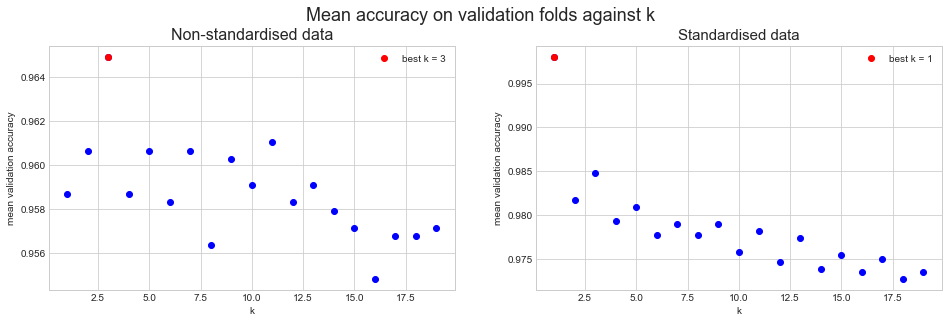

In [727]:
#plotting
best_k_index = int(np.where(k_range==best_k)[0])

plt.figure(figsize=(16, 4.5))
plt.subplot(1, 2, 1)
plt.plot(k_range, k_scores, 'o', color = "b")
plt.plot(k_range[best_k_index], k_scores[best_k_index], 
         'ro', label=f"best k = {best_k}")
plt.xlabel("k")
plt.ylabel("mean validation accuracy")
plt.title("Non-standardised data", fontsize=16)
plt.legend(loc="upper right")

best_k_index_st = int(np.where(k_range==best_k_st)[0])
plt.subplot(1, 2, 2)
plt.plot(k_range, k_scores_st, 'o', color = "b")
plt.plot(k_range[best_k_index_st], k_scores_st[best_k_index_st], 
         'ro', label=f"best k = {best_k_st}")
plt.xlabel("k")
plt.ylabel("mean validation accuracy")
plt.title("Standardised data", fontsize=15)
plt.legend(loc="upper right")
plt.suptitle("Mean accuracy on validation folds against k", fontsize=18, y=1)

We can see from the plots that the optimal hyperparameter k depends on whether the data has been standardised before running the algorithm. The non-standardised data admits an optimal k=3, whereas for the standardised data, we obtain k=1. The corresponding validation accuracy is higher in the standardised case. In order to detect any overfitting, we now test the classifiers on the test data.

### 2.1.2 Testing
With the obtained optimal k values, we retrain the classifiers on the whole training data (both on the standardised and non-standardised versions). We compare the performance of both, on the training and test data, using $$\text{accuracy}=\frac{\text{TP+TN}}{{N_{\text{validation}}}} \quad \text{where TP= #true positives, TN= #true negatives}.$$
Since our data is imbalanced, $\text{TN}$ has a significant contribution in the accuracy, which may lead us to false conclusions. Hence we also compute the precision, recall and F-score metrics, as these are independent of $\text{TN}$.
$$\text{precision}=\frac{\text{TP}}{{\text{TP+FP}}},
\quad \text{recall}=\frac{\text{TP}}{{\text{TP+FN}}},
\quad \text{F-score}=2\cdot \frac{\text{precision}\cdot\text{recall}}{{\text{precision+recall}}},$$
where $\text{FP = #false positives},$ $\text{FN = #false negatives}$.

In [746]:
#non-standardised data
score_train, pred_train = score(X_train, y_train, X_train, y_train, k=3)
score_test, pred_test = score(X_train, y_train, X_test, y_test, k=3)
#standardised data
score_train_st, pred_train_st = score(X_train_st, y_train_st, X_train_st, y_train_st, k=1)
score_test_st, pred_test_st = score(X_train_st, y_train_st, X_test_st, y_test_st, k=1)

In [752]:
def eval_meas(y_pred, y_true):
    """Return the precision, recall and F-score of a prediction."""
    TP = np.sum([1 for i in range(len(y_pred)) if (y_pred[i] == y_true[i] and y_true[i] == 1)])
    TN = np.sum([1 for i in range(len(y_pred)) if (y_pred[i] == y_true[i] and y_true[i] == -1)])
    FP = np.sum([1 for i in range(len(y_pred)) if (y_pred[i] == 1 and y_true[i] == -1)])
    FN = np.sum([1 for i in range(len(y_pred)) if (y_pred[i] == -1 and y_true[i] == 1)])
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F_score = 2*(precision * recall)/(precision + recall)
    return precision, recall, F_score

precision, recall, F_score = eval_meas(pred_test, y_test)
precision_st, recall_st, F_score_st = eval_meas(pred_test_st, y_test)

In [756]:
non_st = np.array([3, np.round(score_train, 3), score_test, 
                   precision, np.round(recall, 3), np.round(F_score, 3)])
st = np.array([1, np.round(score_train_st, 3), score_test_st, 
               precision_st, np.round(recall_st, 3), np.round(F_score_st, 3)])

kNN_df = pd.DataFrame(np.array([non_st, st]), 
                           columns=np.array(["Optimal k", "In-sample accuracy", "Out-of-sample accuracy",
                                            "Out-of-sample precision", "Out-of-sample recall", "Out-of-sample F-score"]),
                           index = np.array(["Non-standardised data", "Standardised data"]))
kNN_df

,Optimal k,In-sample accuracy,Out-of-sample accuracy,Out-of-sample precision,Out-of-sample recall,Out-of-sample F-score
Non-standardised data,3.0,0.975,0.92,1.0,0.781,0.877
Standardised data,1.0,1.000,1.00,1.0,1.000,1.000


The above results show that kNN performed perfectly on the standardised data, with k=1. The perfect in-sample accuracy is not surprising, because the k-nearest neighbours of a datapoint include the data point itself, if it is in the training set. This means that by setting k=1, we classify each data point by looking at its label only - a classification that is perfect by definition (but not useful). The more surprising result is the out-of-sample accuracy for standardised data. It indicates that the nearest neighbour in the train data of a malignant point in the test data is malignant. Given the imbalancedness of the train data, this shows that malignant data points are strongly clustered together in the parameter space. It would be interesting to visualise this using clustering methods.

In the first glance, the non-standardised case also works well, but looking at the out-of-sample recall reveals that this is not the case.

<a name="q22"></a>

## 2.2 Random forest [^](#outline)
Random forests are an enesemble of decision trees, with an extra layer of randomness. Decision trees aim to partition the space of predictors by successively splitting it into partitions of the space. The goal is to ensure that different classes are in different regions, and preferably samples from the same class are in the same region. The loss function takes in the classification quality in each region of a split, and gives an information theoretic measure for the split.

Since decision trees are prone to overfitting, random forests are introduced. These combine decision trees in the following way.
1. Bootstrap B random samples of size N' from the training data.
2. For each B subsets, fit a decision tree (thus obtain an enesemble of models).
3. Given a variable to predict, aggregate the resulting probability vectors by taking the average over all trees.
4. Assign the variable to the class with highest probability.

Random forests are a good option to use when our aim is not to understand which predictors are important, since this is hard to gauge due to the aggregation step. Since out goal in this exercise is only classification (and not to understand why a tomour is malignant), we do not miss out on this drawback in interpretability.

### 2.2.1 Implementation and cross validation
In this section, we implement a random forest classifier with cross-entropy to measure the goodness of the splits. The cross-entropy is defined as
$$\text{CE}[\pi(R_{\alpha})] = -\sum_{q=1}^Q {\pi(R_{\alpha}) \log(1-\pi(R_{\alpha}})),$$
where $R_{\alpha}$ is a region, and the coordinates of the probability vector $\pi(R_{\alpha})$ the probabilities of belonging both to $R_{\alpha}$ and to a certain class (out of the $Q$ classes).

We also perform 5-fold cross-validation to optimize over the hyperparameters $B$ and the maximum depth of the tree. Since random forests are computationally expensive to train and converge fastm we scan the sets $\text{B} \in \{4, 5, 6, 7, 8\}$ and $\text{max depth} \in \{ 6, 7, 8, 9, 10\}$.

In [523]:
X_train, y_train, X_test, y_test, feature_names = prepare_data(tum_train, tum_test, method = "RF")

y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [831]:
def entropy(y, sample_weights):
    """ 
    Calculate the entropy for labels.
    Arguments:
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
    Returns:
        (float): the entropy for y.
    """

    # count different labels in y，and store in label_weights
    # initialize with zero for each distinct label.
    label_weights = {yi: 0 for yi in set(y)}  
    for yi, wi in zip(y, sample_weights):
        label_weights[yi] += wi

    total_weight = sum(label_weights.values())
    E = 0 
    for label, weight in label_weights.items():
        p = weight / total_weight
        E -= p*np.log(p)

    return E

def split_samples(X, y, sample_weights, column, value, categorical):
    """
    Return the split of data whose column-th feature:
        1. equals value, in case `column` is categorical, or
        2. less than value, in case `column` is not categorical (i.e. numerical)

    Arguments:
        X: training features, of shape (N, D).
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
        column: the column of the feature for splitting.
        value: splitting threshold  the samples 
        categorical: boolean value indicating whether column is a categorical variable or numerical.
    Returns:
        tuple(np.array, np.array): tuple of subsets of X splitted based on column-th value.
        tuple(np.array, np.array): tuple of subsets of y splitted based on column-th value.
        tuple(np.array, np.array): tuple of subsets of sample weights based on column-th value.
    """ 

    if categorical:
        left_mask =(X[:, column] == value)
    else:
        left_mask = (X[:, column] < value)
  
    X_left, X_right = X[left_mask, :], X[~left_mask, :]
    y_left, y_right = y[left_mask], y[~left_mask]
    w_left, w_right  = sample_weights[left_mask], sample_weights[~left_mask]

    return (X_left, X_right), (y_left, y_right), (w_left, w_right)

def split_value(X, y, sample_weights, column, categorical):
    """
    Calculate the threshold based on `column` with the split that minimizes the cross-entropy.
    Arguments:
        X: training features, of shape (N, D).
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
        column: the column of the feature for calculating. 0 <= column < D
        categorical: boolean value indicating whether column is a categorical variable or numerical.
    Returns:
        (float, float): the resulted entropy and the corresponding value used in splitting.
    """
  
    unique_vals = np.unique(X[:, column])

    assert len(unique_vals) > 1, f"There must be more than one distinct feature value. Given: {unique_vals}."

    entropy_current, threshold = np.inf, None
  
    # split the values of i-th feature and calculate the cost 
    for value in unique_vals:
        (X_l, X_r), (y_l, y_r), (w_l, w_r) = split_samples(X, y, sample_weights, 
                                                       column, value, categorical) ## <-- EDIT THIS LINE

        # if one of the two sides is empty, skip this split.
        if len(y_l) == 0 or len(y_r) == 0:
            continue

        p_left = sum(w_l)/(sum(w_l) + sum(w_r))
        p_right = 1 - p_left
        new_cost = p_left * entropy(y_l, w_l) + p_right * entropy(y_r, w_r) ## <-- EDIT THIS LINE
        if new_cost < entropy_current:
            entropy_current, threshold = new_cost, value

    return entropy_current,  threshold


def split_rf(n_features, X, y, sample_weights, columns_dict):
    """
    Choose the best feature to split according to criterion.
    Args:
        X: training features, of shape (N, D).
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
    Returns:
        (int, float): the best feature index and value used in splitting.
            If the feature index is None, then no valid split for the current Node.
    """
    columns = np.random.choice(list(columns_dict.keys()), n_features, replace=False)
    columns_dict = {c: columns_dict[c] for c in columns}
    
    # initialize `split_column` to None, so if None returned
    #this means there is no valid split at the current node.
    min_entropy, split_column, split_val = np.inf, 0, 0
    for column, categorical in columns_dict.items():
        # skip column if samples are not seperable by that column.
        if len(np.unique(X[:, column])) < 2:
            continue

        new_entropy, val = split_value(X, y, sample_weights, column, categorical)     
        # minimum search
        if new_entropy < min_entropy:
            min_entropy, split_column, split_val = new_entropy, column, val

    return min_entropy, split_column, split_val

def majority_vote(y, sample_weights):
    """
    Return the label which appears the most in y.
    Args:
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
    Returns:
        (int): the majority label
    """
    majority_label = {yi: 0 for yi in set(y)}

    for yi, wi in zip(y, sample_weights):
        majority_label[yi] += wi 
    return  max(majority_label, key=majority_label.get)

def build_tree_rf(n_features, X, y, sample_weights, columns_dict, feature_names, depth,  max_depth, min_samples_leaf=2):
    """Build the decision tree according to the data.
    Args:
        X: (np.array) training features, of shape (N, D).
        y: (np.array) vector of training labels, of shape (N,).
        sample_weights: None here
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
        feature_names (list): record the name of features in X in the original dataset.
        depth (int): current depth for this node.
    Returns:
        (dict): a dict denoting the decision tree (binary-tree). Each node has seven attributes:
            1. 'feature_name': The column name of the split.
            2. 'feature_index': The column index of the split.
            3. 'value': The value used for the split.
            4. 'categorical': indicator for categorical/numerical variables.
            5. 'majority_label': For leaf nodes, this stores the dominant label. Otherwise, it is None.
            6. 'left': The left sub-tree with the same structure.
            7. 'right' The right sub-tree with the same structure.
        Example:
            mytree = {
              'feature_name': 'petal length (cm)',
              'feature_index': 2,
              'value': 3.0,
              'categorical': False,
              'majority_label': None,
              'left': {
                  'feature_name': str,
                  'feature_index': int,
                  'value': float,
                  'categorical': bool,
                  'majority_label': None,
                  'left': {..etc.},
                  'right': {..etc.}
              }
              'right': {
                  'feature_name': str,
                  'feature_index': int,
                  'value': float,
                  'categorical': bool,
                  'majority_label': None,
                  'left': {..etc.},
                  'right': {..etc.}
              }
          }
    """
    # include a clause for the cases where (i) all lables are the same, 
    # (ii) depth exceed (iii) X is too small
    if len(np.unique(y)) == 1 or depth>=max_depth or len(X)<=min_samples_leaf: 
        return {'majority_label': majority_vote(y, sample_weights)}
  
    else:
        entropy, split_index, split_val = split_rf(n_features, X, y, sample_weights, columns_dict)
    
    # If entropy is infinity, it means that samples are not seperable by the sampled features.
    if entropy == np.inf:
        return {'majority_label': majority_vote(y, sample_weights)}
    categorical = columns_dict[split_index]
    (X_l, X_r), (y_l, y_r), (w_l, w_r) = split_samples(X, y, sample_weights,
                                                       split_index, split_val, categorical)
    return {
        'feature_name': feature_names[split_index],
        'feature_index': split_index,
        'value': split_val,
        'categorical': categorical,
        'majority_label': None,
        'left': build_tree_rf(n_features, X_l, y_l, w_l, columns_dict, feature_names,
                              depth + 1, max_depth, min_samples_leaf),
        'right': build_tree_rf(n_features, X_r, y_r, w_r, columns_dict, feature_names,
                               depth + 1, max_depth, min_samples_leaf)
    }


def train_rf(B, n_features, X, y, columns_dict, feature_names, max_depth = 10, sample_weights=None):
    """
    Build the decision tree according to the training data.
    Args:
      B: number of decision trees.
      X: np.ndarray: training features, of shape (N, D). Each X[i] is a training sample.
      y: np.array: vector of training labels, of shape (N,). y[i] is the label
                      for X[i], and each y[i] is
      an integer 1 or -1
      feature_names(list): record the name of features in X in the original dataset.
      columns_dict: a dictionary mapping column indices to whether the column is
                    categorical or numerical variable.
      sample_weights: weights for each samples, of shape (N,).
    """
    if sample_weights is None:
        # if the sample weights is not provided, we assume the samples have uniform weights
        sample_weights = np.ones(X.shape[0]) / X.shape[0]
    else:
        sample_weights = np.array(sample_weights) / np.sum(sample_weights)

    feature_names = feature_names
    N = X.shape[0]
    training_indices = np.arange(N)
    trees = []

    for _ in range(B):
        sample = np.random.choice(training_indices, N, replace=True)
        X_sample = X[sample, :]
        y_sample = y[sample]
        w_sample = sample_weights[sample]
        tree = build_tree_rf(n_features, X_sample, y_sample, w_sample, columns_dict,
                         feature_names, depth = 1, max_depth = max_depth)
        trees.append(tree)
        #print("Tree done")
    return trees

In [832]:
columns_dict = {index: False for index in range(X_train.shape[1])}
training_weights = np.ones_like(y_train) / len(y_train)

In [833]:
def classify(tree, x):
    """
    Classify a single sample with the fitted decision tree.
    Args:
        tree: fitted decision tree
        x: (np.array) a single sample features, of shape (D,).
    Returns:
      (int): predicted testing sample label.
    """
    if tree['majority_label'] is not None: 
        return tree['majority_label']

    elif tree['categorical']:
        if x[tree['feature_index']] == tree['value']:
            return classify(tree['left'], x)
        else:
            return classify(tree['right'], x)

    else:
        #print(x[tree['feature_index']] )
        if x[tree['feature_index']] < tree['value']:
            return classify(tree['left'], x)
        else:
            return classify(tree['right'], x)

def predict_rf(rf, X):
    """
    Predict classification results for X.
    Args:
        rf: A trained random forest through train_rf function.
        X: (np.array) testing sample features, of shape (N, D).
    Returns:
        (np.array): predicted testing sample labels, of shape (N,).
    """

    def aggregate(decisions):
        """Aggregate models."""
        count = defaultdict(int)
        for decision in decisions:
            count[decision] += 1
        return max(count, key=count.get)

    if len(X.shape) == 1:
        return aggregate([classify(tree, X) for tree in rf])
    else:
        return np.array([aggregate([classify(tree, x) for tree in rf]) for x in X])

def rf_score(rf, X_test, y_test):
    """Find the accuracy score of a ranfom forest fr."""
    y_pred = predict_rf(rf, X_test)
    return np.mean(y_pred==y_test)

In [834]:
def cross_validation_score_rf(X_train, y_train, feature_names, folds, B, max_depth):
    """Return the average score of the raindom forests trained
    on the training folds and evaluated on the validation folds."""
    scores = []
    for i in range(len(folds)):
        val_indexes = folds[i]
        train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))
    
        X_train_i = X_train[train_indexes, :]
        y_train_i = y_train[train_indexes]
        
        X_val_i = X_train[val_indexes, :]
        y_val_i = y_train[val_indexes]
    
        forest_i = train_rf(B, n_features, X_train_i, y_train_i, columns_dict,
                        feature_names=train_indexes, max_depth = max_depth)

        score_i = rf_score(forest_i, X_val_i, y_val_i)
        scores.append(score_i)

    # Return the average score
    return sum(scores) / len(scores)

def choose_best_params(X_train, y_train, feature_names, folds, B_range, max_depth_range):
    """Determine the best values for B (#trees) and max_depth in B_range and max_depth_range."""
    score_matrix = np.zeros((len(B_range), len(max_depth_range)))
  
    for i, B in enumerate(tqdm(B_range)):
        for j, max_depth in enumerate((tqdm(max_depth_range))):
            score_matrix[i, j] = cross_validation_score_rf(X_train, y_train, feature_names, folds, B=B, max_depth=max_depth)
            print(f'Accuracy score for B={B} and max_depth={max_depth} : {score_matrix[i, j]:.3f}')
    
    def matrix_argmax(A):
        """Return the maximum value and corresponding indices of a matrix."""
        max_val = A.max()
        max_xy = np.where(A == max_val)
        return [max_val, [int(max_xy[0]), int(max_xy[1])]]

    best_score, best_param_index = matrix_argmax(score_matrix)
    return [B_range[best_param_index[0]], max_depth_range[best_param_index[1]]], score_matrix

In [363]:
n_features = X_train.shape[1]//3
folds_indices = np.array_split(np.arange(y_train.shape[0]), 5)
best_params, acc_matrix = choose_best_params(X_train, y_train, feature_names, 
                                             folds_indices, B_range=[4, 5, 6, 7, 8], max_depth_range=[6, 7, 8, 9, 10])

 20%|████████████████▌                                                                  | 1/5 [11:52<47:31, 712.95s/it]

Accuracy score for B=4 and max_depth=6 : 0.982



 40%|█████████████████████████████████▏                                                 | 2/5 [23:54<35:53, 717.92s/it]

Accuracy score for B=4 and max_depth=7 : 0.981



 60%|█████████████████████████████████████████████████▊                                 | 3/5 [35:59<24:02, 721.10s/it]

Accuracy score for B=4 and max_depth=8 : 0.980



 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [47:19<11:45, 705.03s/it]

Accuracy score for B=4 and max_depth=9 : 0.981



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Accuracy score for B=4 and max_depth=10 : 0.981



 20%|████████████████▌                                                                  | 1/5 [13:39<54:36, 819.11s/it]

Accuracy score for B=5 and max_depth=6 : 0.981



 40%|█████████████████████████████████▏                                                 | 2/5 [27:28<41:14, 824.90s/it]

Accuracy score for B=5 and max_depth=7 : 0.980



 60%|█████████████████████████████████████████████████▊                                 | 3/5 [41:55<28:08, 844.41s/it]

Accuracy score for B=5 and max_depth=8 : 0.983



 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [55:48<13:59, 839.97s/it]

Accuracy score for B=5 and max_depth=9 : 0.984



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Accuracy score for B=5 and max_depth=10 : 0.984



 20%|████████████████▏                                                                | 1/5 [16:07<1:04:30, 967.60s/it]

Accuracy score for B=6 and max_depth=6 : 0.979



 40%|█████████████████████████████████▏                                                 | 2/5 [33:01<49:44, 994.92s/it]

Accuracy score for B=6 and max_depth=7 : 0.982



 60%|█████████████████████████████████████████████████▏                                | 3/5 [50:46<34:13, 1026.85s/it]

Accuracy score for B=6 and max_depth=8 : 0.981



 80%|████████████████████████████████████████████████████████████████                | 4/5 [1:08:02<17:10, 1030.37s/it]

Accuracy score for B=6 and max_depth=9 : 0.987



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Accuracy score for B=6 and max_depth=10 : 0.984



 20%|████████████████                                                                | 1/5 [19:06<1:16:27, 1146.86s/it]

Accuracy score for B=7 and max_depth=6 : 0.982



 40%|████████████████████████████████▊                                                 | 2/5 [38:44<58:14, 1164.85s/it]

Accuracy score for B=7 and max_depth=7 : 0.986



 60%|█████████████████████████████████████████████████▏                                | 3/5 [58:47<39:24, 1182.17s/it]

Accuracy score for B=7 and max_depth=8 : 0.986



 80%|████████████████████████████████████████████████████████████████                | 4/5 [1:19:39<20:09, 1209.91s/it]

Accuracy score for B=7 and max_depth=9 : 0.982



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Accuracy score for B=7 and max_depth=10 : 0.982



 20%|████████████████                                                                | 1/5 [22:02<1:28:08, 1322.15s/it]

Accuracy score for B=8 and max_depth=6 : 0.982



 40%|████████████████████████████████                                                | 2/5 [45:06<1:07:55, 1358.62s/it]

Accuracy score for B=8 and max_depth=7 : 0.982



 60%|████████████████████████████████████████████████                                | 3/5 [1:07:24<44:59, 1349.51s/it]

Accuracy score for B=8 and max_depth=8 : 0.981



 80%|████████████████████████████████████████████████████████████████                | 4/5 [1:30:15<22:37, 1357.70s/it]

Accuracy score for B=8 and max_depth=9 : 0.984



100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [7:05:31<00:00, 5106.34s/it]

Accuracy score for B=8 and max_depth=10 : 0.984


In [844]:
rf_df = pd.DataFrame(acc_matrix, 
                     columns=np.array([f"Max depth = {i}" for i in range(6, 11)]), 
                     index=np.array([f"Number of trees = {i}" for i in range(4, 9)]))

print(f'Best parameters: number of trees = {best_params[0]}, max depth = {best_params[1]}')
rf_df

Best parameters: number of trees = 6, max depth = 9


,Max depth = 6,Max depth = 7,Max depth = 8,Max depth = 9,Max depth = 10
Number of trees = 4,0.982461,0.980902,0.979735,0.980512,0.981292
Number of trees = 5,0.980511,0.980125,0.983242,0.984411,0.984019
Number of trees = 6,0.978953,0.981682,0.981294,0.986748,0.984019
Number of trees = 7,0.981682,0.985969,0.985581,0.982071,0.982074
Number of trees = 8,0.981684,0.982075,0.981293,0.984020,0.984410


Text(0.5, 1.0, 'Accuracy against maximum depth of trees with number of trees=6')

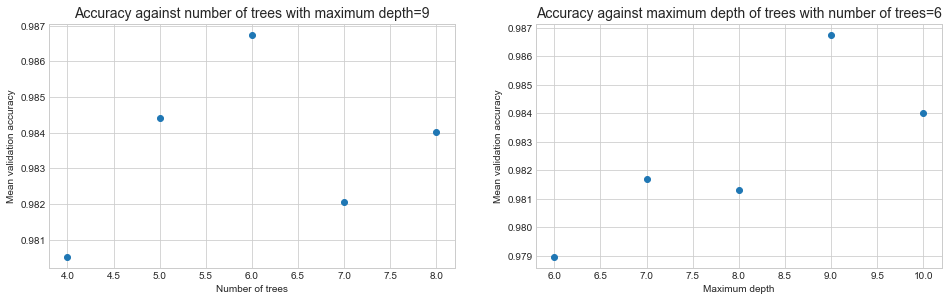

In [849]:
plt.figure(figsize=(16, 4.5))
plt.subplot(1, 2, 1)
plt.plot(range(4, 9), acc_matrix[:, 3], 'o')
plt.xlabel("Number of trees")
plt.ylabel("Mean validation accuracy")
plt.title("Accuracy against number of trees with maximum depth=9", fontsize=14)
plt.subplot(1, 2, 2)
plt.plot(range(6, 11), acc_matrix[2, :], 'o')
plt.xlabel("Maximum depth")
plt.ylabel("Mean validation accuracy")
plt.title("Accuracy against maximum depth of trees with number of trees=6", fontsize=14)

Thus, we obtained that 6 trees of maximum depth 9 perform the best on the train data, giving an average validation accuracy of 0.986748. We now evaluate this model on the test dataset.

### 2.2.2 Testing

In [770]:
B = 6
max_depth = 9
forest = train_rf(B, n_features, X_train, y_train, columns_dict, feature_names, max_depth)
y_test_pred = predict_rf(forest, X_test)

In [791]:
def confusion(y_pred, y_true):
    """Return the accuracy measures computed from the confusion matrix."""
    TP = np.sum([1 for i in range(len(y_pred)) if (y_pred[i] == y_true[i] and y_true[i] == 1)])
    TN = np.sum([1 for i in range(len(y_pred)) if (y_pred[i] == y_true[i] and y_true[i] == -1)])
    FP = np.sum([1 for i in range(len(y_pred)) if (y_pred[i] == 1 and y_true[i] == -1)])
    FN = np.sum([1 for i in range(len(y_pred)) if (y_pred[i] == -1 and y_true[i] == 1)])
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F_score = 2*(precision * recall)/(precision + recall)
    specificity = TN/(TN+FP)
    conf_matrix = pd.DataFrame([[TP, FP], [FN, TN]], index=["Predicted: Yes", "Predicted: No"], 
                               columns=["Actual: Yes", "Actual: No"])
    return precision, recall, F_score, specificity, conf_matrix

In [792]:
precision, recall, F_score, specificity, conf_matrix = confusion(y_test_pred, y_test)
accuracy = np.mean(y_test_pred==y_test)
data = np.array([[np.round(accuracy, 3)], [precision], [np.round(recall, 3)], [np.round(F_score, 3)], [specificity]])

fr_test_df = pd.DataFrame(data, columns=["Radom forest (6, 9)"],  index=["Out-of-sample accuracy","Out-of-sample precision",
                                           "Out-of-sample recall", "Out-of-sample F-score",
                                          "Out-of-sample specificity"]).T
fr_test_df

,Out-of-sample accuracy,Out-of-sample precision,Out-of-sample recall,Out-of-sample F-score,Out-of-sample specificity
"Radom forest (6, 9)",0.975,1.0,0.932,0.965,1.0


In [793]:
conf_matrix

,Actual: Yes,Actual: No
Predicted: Yes,68,0.0
Predicted: No,5,127.0


At first glance, we see that chosen random forest classifier performed well on the unseen dataset, only misclassifying 5 data points, which are false negatives (type II error). In a medical setting such as ours, this error carries a lot of weight because failing to diagnose a malignant tumour can have grave consequences for the patient.

The lack of type I error (false positives) supplies the perfect precision and specificity rates. In our case, they are misleading, indicating a perfect model. Accuracy is also high because of the imbalanced nature of the data: true negatives dominate the fraction. The measure most dependent on false negatives (type II error) is recall, and we can see that this has the lowest value. Finally, the F-score, as the harmonic mean between precision and recall, is in-between these two values. 

The F-score is a particularly suitable measure of accuracy when (i) the data is unbalanced and (ii) when the two errors have different priority, so exactly in our case. It can be adapted to accommodate (ii), by making the recall more important. The adapted F-score $F_{\beta}$ is defined as:
$$F_{\beta} = (1+\beta^2)\frac{\text{precision} \cdot \text{recall}}{(\beta^2 \cdot \text{precision}) + \text{recall}}.$$

The value of $\beta$ means that the recall is considered to be $\beta$ times more important than the precision. Plugging in $\beta=2$, a standard choice, we obtain $F_2 \approx 0.9444$. This shows that the standard measures might be misleading for special cases, such as (i) or (ii). It is important to be aware of at the priorities of the classification, and construct an accuracy measure that accommodates them. Although our classifier is not very bad, the above analysis has shown that it is not excellent either.

A possible improvement could be to leave out the argmax step of the classification, and interpret the largest probability as the 'confidence' of the model in the classification. One would hope that those data points that were originally false negatives would have a lower confidence associated to them. In a medical settings, these dubious data points could be checked again in order to make sure they are classified correctly (when there is no ground truth available). 

<a name="q23"></a>

## 2.3 Support Vecor Machines[^](#outline)
Support Vector Machines (SVMs) are binary classifiers adopting a geometrical perspective. They aim to find a boundary in the parameter space that will optimally separate the samples that belong to the two classes. The simplest version is the hard-margin linear SVMs, where this boundary is a hyperplane. However, if the data points are not separable in the parameter space (which is usually the case), classification with a hard-margin SVM becomes infeasible. This motivates soft-margin SVM, which relax the conditions of hard-margin SVMs. They include a penalty $\lambda$ in the loss function which penalise the violations for the separating hyperplane. 

The loss function for hard-margin SVMs is
$$\min_w \frac{1}{2} \|w\|^2, \quad  \text{ subject to } \quad y^{(i)}(x^{(i)} \cdot w + b) \geq 1  \quad \text{ for } i=1, ..., N.$$

For soft-margin SVMs, this is modified to
$$\min_w \frac{1}{2} \|w\|^2 + \lambda \sum_{i=1}^n{\zeta^{(i)}}, \quad  \text{ subject to } \quad 1-y^{(i)}(x^{(i)} \cdot w + b) \leq \zeta^{(i)}  \quad \text{ for } i=1, ..., N,$$

where $\zeta^{(i)}$ is the hinge loss, defined as $\zeta^{(i)} = \max(0, 1-y^{(i)}(x^{(i)} \cdot w + b)) \geq 0.$  This makes sense as $1-y^{(i)}(x^{(i)} \cdot w + b) \leq 0$ corresponds to no violation of the boundary, the hard-margin case.


SVMs can be made even more flexible by introducing kernel functions. These are suitable algorithms for problems arising in computational biology and medicine, which usually involve high-dimensional, noisy data. In this section, we implement a soft-margin SVM for our (low-dimensional) classification data. We train out SVM on both the imbalanced and balanced training datasets and compare the results.

### 2.3.1 Implementation and cross-validation

The below chunks implement the soft-margin SVM with hardness parameter $\lambda$. The optimization step is carried-out using stochastic gradient descent. First, we perform 5-fold cross-validation and then look at the in-sample accuracy obtained when training on the whole dataset. The range for $\lambda$ to scan was chosen to be an exponentially growing sequence. A couple of refinements have shown that the realistic region for $\lambda$ is $(2^{10}, 2^{18})$. Then, subsequent refinements were carried out first with exponential, then with linearly spaced search ranges. This was to ensure that (i) the correct magnitude gets picked out fast and (ii) in case there are oscillations, we do not miss out on detecting good values for that the exponential range would not cover.

In [76]:
X_train, y_train, X_test, y_test = prepare_data(tum_train, tum_test, method = "SVM")
folds_indices = np.array_split(np.arange(len(y_train)), 5)

In [77]:
def compute_cost(w, X, y, regul_strength=1e5):
    """Calculate the cost function using hinge loss."""
    n = X.shape[0]
    distances = 1 - y * (X @ w)
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge = regul_strength * distances.mean()
    return 0.5 * np.dot(w, w) + hinge # calculate cost

# calculate gradient of cost
def calculate_cost_gradient(w, X_batch, y_batch, regul_strength=1e5):
    """Return the gradient of the cost function for stochastic gradient descent."""
    if type(y_batch) == np.float64:  # if only one example is passed
        y_batch = np.asarray([y_batch])
        X_batch = np.asarray([X_batch])  # gives multidimensional array

    distance = 1 - (y_batch * (X_batch @ w))
    dw = np.zeros(len(w))

    for ind, d in enumerate(distance):
        if max(0, d)==0:
            di = w
        else:
            di = w - (regul_strength * y_batch[ind] * X_batch[ind])
        dw += di

    return dw/len(y_batch)  # return the average over the batch

def sgd(X, y, batch_size=16, max_iterations=2000,stop_criterion=0.01,learning_rate=1e-5,regul_strength=1e5,print_outcome=False):
    """Find the optimal weights by stochastic gradient descent."""
    weights = np.zeros(X.shape[1])  # initialise zero weights
    nth = 0
    prev_cost = np.inf  # start at infinity as we want to minimize
    indices = np.arange(len(y))
    
    #stochastic gradient descent
    for iteration in range(1, max_iterations):  
        # shuffle to prevent repeating update cycles
        np.random.shuffle(indices)
        batch_idx = indices[:batch_size]
        X_b, y_b = X[batch_idx], y[batch_idx]
        for xi, yi in zip(X_b, y_b):
            ascent = calculate_cost_gradient(weights, xi, yi, regul_strength)
            weights = weights - (learning_rate * ascent)

        # convergence check on 2^n'th iteration
        if iteration == 2**nth or iteration == max_iterations - 1:
            # compute cost
            cost = compute_cost(weights, X, y, regul_strength)
            if print_outcome:
                print("Iteration is: {}, Cost is: {}".format(iteration, cost))
            # stop criterion
            if abs(prev_cost - cost) < stop_criterion * prev_cost:
                return weights
              
            prev_cost = cost
            nth += 1
    
    return weights

def SVM_score(w, X, y):
    """Return the accuracy score of the SVM prediction given w."""
    y_preds = np.sign(X @ w)
    return np.mean(y_preds == y)

In [78]:
def cross_val_evaluate(X_train, y_train, folds_indices, lambd_range):
    """Perform cross-validation for SVM in the given fold indices
    to find the optimal hardness hyperparameter lambda."""
    #folds = cross_val_split(data.shape[0], num_folds)
    train_scores = []
    val_scores = []
    
    mean_train_scores = []
    mean_val_scores = []
    all_lambd_weights = []

    for lambd in tqdm(lambd_range):
        # will record the average weights obtained for all lambdas
        avg_weights = np.zeros(X_train.shape[1])
        
        for i in range(len(folds_indices)):
            val_indices = folds_indices[i]
            # define the training set
            train_indices = list(set(range(X_train.shape[0])) - set(val_indices))

            X_train_i = X_train[train_indices,  :]
            y_train_i = y_train[train_indices]

            # define the validation set
            X_val_i = X_train[val_indices,  :]
            y_val_i = y_train[val_indices]
        
            # train the model
            w = sgd(X_train_i, y_train_i, max_iterations=1025, stop_criterion=0.01, 
                    learning_rate=1e-6, regul_strength=lambd)
            avg_weights += w
            
            # evaluate
            train_score = SVM_score(w, X_train_i, y_train_i)
            val_score = SVM_score(w, X_val_i, y_val_i)

            train_scores.append(train_score)
            val_scores.append(val_score)
        
        avg_weights = avg_weights / len(folds_indices)
        all_lambd_weights.append(avg_weights)
        
        mean_train = np.mean(train_scores)
        mean_val = np.mean(val_scores)        
        mean_train_scores.append(mean_train)
        mean_val_scores.append(mean_val)
        
        #functionality to monitor progress
        #if mean_val >= 0.98:
        #    print(f"Mean training accuracy for lambda = {lambd}: {mean_train}")
        #    print(f"Mean validation accuracy for lambda = {lambd}: {mean_val}")
        
    best_lambd_ind = np.argmax(mean_val_scores)       

    return [lambd_range[best_lambd_ind], mean_train_scores, mean_val_scores, all_lambd_weights]

In [121]:
lambd_range_exp = [2**i for i in np.linspace(10, 18, 40)]
best_lambd_cv, mean_train_scores_cv, mean_val_scores_cv, all_lambd_weights_exp = cross_val_evaluate(
    X_train, y_train, folds_indices, lambd_range=lambd_range_exp)

print(f"Best lambda={best_lambd_cv} , best validation accuracy={max(mean_val_scores_cv)}")

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:03<00:00,  1.58s/it]

Best lambda=11482.74135371431 , best validation accuracy=0.9874435452131312


In [122]:
lambd_range_lin = np.linspace(10, 262144, 40)
best_lambd_cv_lin, mean_train_scores_cv_lin, mean_val_scores_cv_lin, all_lambd_weights_lin = cross_val_evaluate(
    X_train, y_train, folds_indices, lambd_range=lambd_range_lin)

print(f"Best lambda={best_lambd_cv_lin} , best validation accuracy={max(mean_val_scores_cv_lin)}")

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:00<00:00,  1.52s/it]

Best lambda=201651.53846153847 , best validation accuracy=0.9782143740590754


In [123]:
lambd_range_ref = np.linspace(16000, 30000, 40)
best_lambd_cv_ref, mean_train_scores_cv_ref, mean_val_scores_cv_ref, all_lambd_weights_ref = cross_val_evaluate(
    X_train, y_train, folds_indices, lambd_range=lambd_range_ref)

print(f"Best lambda={best_lambd_cv_ref} , best validation accuracy={max(mean_val_scores_cv_ref)}")

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:03<00:00,  1.59s/it]

Best lambda=16000.0 , best validation accuracy=0.9890898885779082


In [124]:
lambd_range_ref_1 = np.linspace(14000, 20000, 40)
best_lambd_cv_ref_1, mean_train_scores_cv_ref_1, mean_val_scores_cv_ref_1, all_lambd_weights_ref = cross_val_evaluate(
    X_train, y_train, folds_indices, lambd_range=lambd_range_ref_1)

print(f"Best lambda={best_lambd_cv_ref_1} , best validation accuracy={max(mean_val_scores_cv_ref_1)}")

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:04<00:00,  1.61s/it]

Best lambda=14153.846153846154 , best validation accuracy=0.9886996457854537


Text(0.5, 1, 'Mean accuracy on validation folds agains lambda')

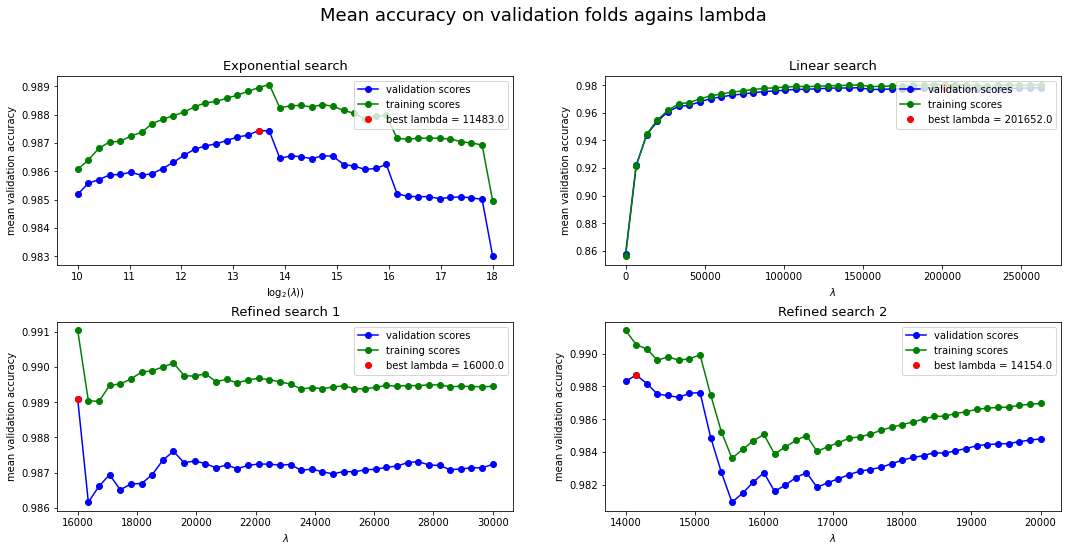

In [125]:
#plotting
best_lambd_index_cv = int(np.where(lambd_range_exp==best_lambd_cv)[0])
best_lambd_index_cv_lin = int(np.where(lambd_range_lin==best_lambd_cv_lin)[0])
best_lambd_index_cv_ref = int(np.where(lambd_range_ref==best_lambd_cv_ref)[0])
best_lambd_index_cv_ref_1 = int(np.where(lambd_range_ref_1==best_lambd_cv_ref_1)[0])

plt.figure(figsize=(18, 8))
plt.subplot(2, 2, 1)
plt.plot(np.log2(lambd_range_exp), mean_val_scores_cv, marker = 'o', color = "b", label= "validation scores")
plt.plot(np.log2(lambd_range_exp), mean_train_scores_cv, marker ='o', color = "g", label= "training scores")
plt.plot(np.log2(lambd_range_exp[best_lambd_index_cv]), mean_val_scores_cv[best_lambd_index_cv], 
         'ro', label=f"best lambda = {np.round(best_lambd_cv)}")
plt.xlabel("$\log_2(\lambda))$")
plt.ylabel("mean validation accuracy")
plt.title("Exponential search", fontsize=13)
plt.legend(loc="upper right")

plt.subplot(2, 2, 2)
plt.plot(lambd_range_lin, mean_val_scores_cv_lin, marker = 'o', color = "b", label= "validation scores")
plt.plot(lambd_range_lin, mean_train_scores_cv_lin, marker ='o', color = "g", label= "training scores")
plt.plot(lambd_range_lin[best_lambd_index_cv_lin], mean_val_scores_cv_lin[best_lambd_index_cv_lin], 
         'ro', label=f"best lambda = {np.round(best_lambd_cv_lin)}")
plt.xlabel("$\lambda$")
plt.ylabel("mean validation accuracy")
plt.title("Linear search", fontsize=13)
plt.legend(loc="upper right")

plt.subplot(2, 2, 3)
plt.plot(lambd_range_ref, mean_val_scores_cv_ref, marker = 'o', color = "b", label= "validation scores")
plt.plot(lambd_range_ref, mean_train_scores_cv_ref, marker ='o', color = "g", label= "training scores")
plt.plot(lambd_range_ref[best_lambd_index_cv_ref], mean_val_scores_cv_ref[best_lambd_index_cv_ref], 
         'ro', label=f"best lambda = {np.round(best_lambd_cv_ref)}")
plt.xlabel("$\lambda$")
plt.ylabel("mean validation accuracy")
plt.title("Refined search 1", fontsize=13)
plt.legend(loc="upper right")

plt.subplot(2, 2, 4)
plt.plot(lambd_range_ref_1, mean_val_scores_cv_ref_1, marker = 'o', color = "b", label= "validation scores")
plt.plot(lambd_range_ref_1, mean_train_scores_cv_ref_1, marker ='o', color = "g", label= "training scores")
plt.plot(lambd_range_ref_1[best_lambd_index_cv_ref_1], mean_val_scores_cv_ref_1[best_lambd_index_cv_ref_1], 
         'ro', label=f"best lambda = {np.round(best_lambd_cv_ref_1)}")
plt.xlabel("$\lambda$")
plt.ylabel("mean validation accuracy")
plt.title("Refined search 2", fontsize=13)
plt.legend(loc="upper right")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)

plt.suptitle("Mean accuracy on validation folds agains lambda", fontsize=18, y=1)

It is important to note that due to the stochasticity of the optimisation, curves are not "zoom-ins" of each other. We can see that results depend highly on the iteration, resulting in non-negligible changes in the optimal $\lambda$. This could be mitigated by averaging over multiple iterations, however I did not have time to implement this. Next, we look at the in-sample-accuracy, as $\lambda$ is varied. This time, we train on the whole training dataset X_train.

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:13<00:00,  2.87it/s]

Best lambda=15259.667404017104 , best validation accuracy=0.9914263445050663


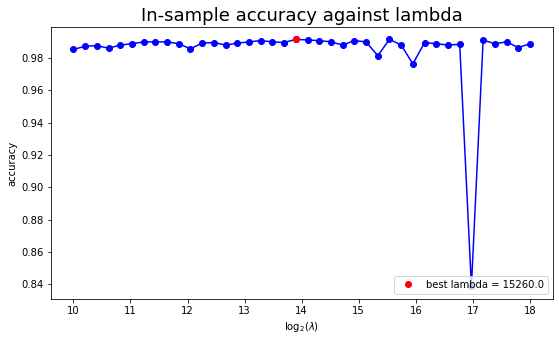

In [106]:
test_scores_is = []
lambd_range = [2**i for i in np.linspace(10, 18, 40)]
for lambd in tqdm(lambd_range):
    w = sgd(X_train, y_train, max_iterations=1025, stop_criterion=0.01, learning_rate=1e-6, regul_strength=lambd)
    y_pred = np.sign(X_train @ w)
    score = SVM_score(w, X_train, y_train)
    test_scores_is.append(score)

best_lambd_is = lambd_range[np.argmax(test_scores_is)]
print(f"Best lambda={best_lambd_is} , best validation accuracy={max(test_scores_is)}")

best_lambd_index_is = int(np.where(lambd_range == best_lambd_is)[0])
plt.figure(figsize=(9, 5))
plt.plot(np.log2(lambd_range), test_scores_is, marker = 'o', color = "b")
plt.plot(np.log2(lambd_range)[best_lambd_index_is], test_scores_is[best_lambd_index_is], 
         'ro', label=f"best lambda = {np.round(best_lambd_is)}")
plt.xlabel("$\log_2(\lambda)$")
plt.ylabel("accuracy")
plt.title("In-sample accuracy against lambda", fontsize=18)
plt.legend(loc="lower right")

The hyperparameter $\lambda$ penalizes deviations from the boundary hyperplane. It affects the width of the hyperplane in the following way. If $\lambda$ is too small, we don't penalize deviations strongly enough, hence the width will be too large, and the SVM and will misclassify many data points. This may be the case even when the data is linearly separable, where hard-margin SVMs would work well. If $\lambda$ is too large, the width is shrinking towards zero, and eventually we recover the hard-margin case. 

The optimal $\lambda$ found by the cross-validation is $\lambda \approx 16000$. This gives a validation accuracy of around 0.989. Due to the oscillations, this result is not 'confident', and the optimum may lie within a range of this value. For the whole training dataset, this value usually slightly lower and has magnitude $10^5$. The high values of $\lambda$ indicate the (almost) linear separability of the training data. This makes sense due to the small number of malignant data points in our training data. The validation folds contain significantly fewer malignant data points than the whole training data, so when optimizing over the mean validation accuracy, we don't need to penalize a lot for violations of the boundary, because the few malignant test data points are less likely to be positioned badly (with respect to linear separation). However, one should note that the results heavily depended on the iteration, and this should be mitigated by averaging over the result of multiple iterations of the training.

The (almost) linear separability is roughly consistent with the results of KNN. Although two clusters may be linearly separable yet have more close neighbours from the other cluster, these two methods tell us that the malignant data points are very similar, but in a slightly different sense.

### 2.3.2 Test dataset
Since the training and test dataset has a different distribution of clusters, the $\lambda$ that is optimal on the training data may not supply the best results for the test data. Therefore, we now look at the out-of-sample accuracy obtained by testing the SVM-s obtained in cross-validation, evaluated on the test set as $\lambda$ is varied. The shown search ranges were again obtained by subsequent refinements. Note that we output the results of both a linear and exponential grid.

We can see on the plots that the accuracies are oscillating as a function of $\lambda$, and this can lead to very different values classified as optimal. The effect of the learning rate on oscillation was examined, and the parameter was decreased to 2e-6 (from the default 1e-5). In order to further mitigate the oscillations, one could peroform multiple runs of the training, and average over the mean validation accuracies.

In [126]:
def roc_curve(y_true, y_pred):
    """
    Arguments:
    y_true: ground truth labels with size (n, )
    y_pred: predictions produced by SVM model with size (n, )
  
    Returns:
    auc: area under the curve (AUC).
    tpr_l: a list of true positive rate (TPR) values for each scanned threshold.
    fpr_l: a list of false positive rate (FPR) values for each scanned threshold.
    thresholds: the scanned thresholds sorted descendingly.
  """
    tp, tn, fp, fn = 0, 0, 0, 0

    for i in range(len(y_true)):
        if y_true[i] == y_pred [i] and y_true[i] == 1: 
            # true positives
            tp +=1
        elif y_true[i] == y_pred [i]:
            # true negatives
            tn += 1
        elif y_true[i] == -1:
            # false positives
            fp += 1
        else:
            # false negatives
            fn += 1

    tpr = tp / (tp + fn)
    fpr = fp / (tn + fp)
    
    return tpr, fpr

In [127]:
def calibrate_folds(X_train, y_train, X_test, y_test, n, lambd_range, all_lambd_w, max_iterations=1025, 
              stop_criterion=0.01, learning_rate=2e-6):
    """Return the accuracy measures corresponding to the cross-validation SVM-s
    when evaluated in the test data. The outputs are averaged over the folds."""
    tpr_l = []
    fpr_l = []
    test_scores = []
    for w in all_lambd_w:
        y_pred = np.sign(X_test @ w)
        score = SVM_score(w, X_test, y_test)
        test_scores.append(score)
        tpr, fpr= roc_curve(y_test, y_pred)
        tpr_l.append(tpr)
        fpr_l.append(fpr)
    
    best_score = np.max(test_scores)
    best_ind = int(np.where(test_scores==best_score)[0][0])
    best_lambd = lambd_range[best_ind]
    return best_lambd, best_score, best_ind, test_scores, tpr_l, fpr_l

def plot_folds(X_train, y_train, X_test, y_test, n, lambd_range, all_lambd_w, max_iterations=1025, 
              stop_criterion=0.01, learning_rate=2e-6):
    """Plot accuracy and ROC curves from the cross-validation SVM results."""
    best_lambd, best_score, ind, test_scores, tpr_l, fpr_l = calibrate_folds(
    X_train, y_train, X_test, y_test, n, lambd_range, all_lambd_w, max_iterations=1025, 
    stop_criterion=0.001, learning_rate=2e-6)
    
    plt.figure(figsize=(18, 6))
    # accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(np.log2(lambd_range), test_scores, marker = 'o', color = "b")
    plt.plot(np.log2(lambd_range[ind]), best_score, 
         'ro', label=f"best lambda = {np.round(lambd_range[ind])}")
    plt.xlabel("$\log_2(\lambda)$")
    plt.ylabel("accuracy")
    plt.title("Out-of-sample accuracy against lambda", fontsize=16)
    plt.legend(loc="lower right")
    
    # ROC plot
    plt.subplot(1, 2, 2)
    plt.title(f"Receiver Operating Curve", size=16)
    plt.plot(fpr_l, tpr_l, 'o', color ='b')
    plt.plot(fpr_l[ind], tpr_l[ind], 'ro', 
             label=f"best lambda = {np.round(best_lambd)}")
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('TPR', size=16)
    plt.xlabel('FPR', size=16)
    plt.legend(loc='lower right')

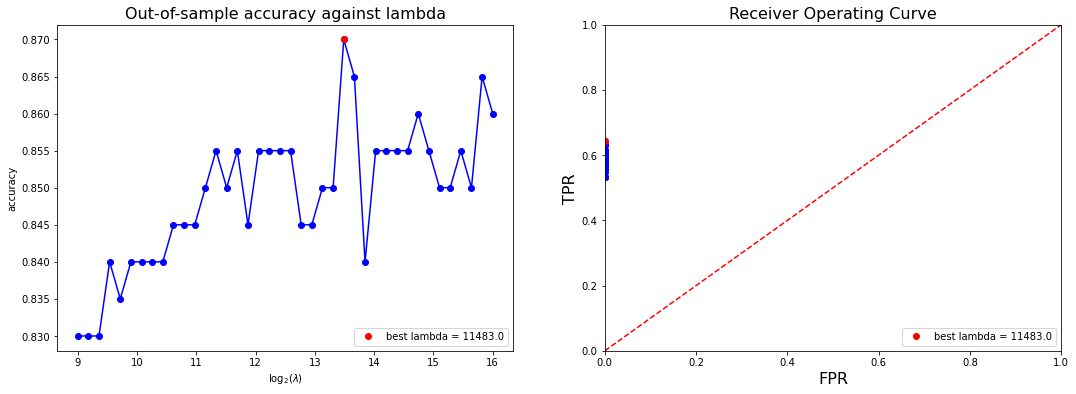

In [128]:
plot_folds(X_train, y_train, X_test, y_test, 1, lambd_range=[2**i for i in np.linspace(9, 16, 40)],
           all_lambd_w = all_lambd_weights_exp)  # exponential range

In the plots above, we can further observe the oscillatory behaviour of the SVM accuracies. When validating on the test dataset, a lower optimal harness hyperparameter was obtained. Due to the oscillations and many similarly high accuracy values, we cannot meaningfully choose the optimal $\lambda$ here. The resulting accuracies is also low, which is supported by the ROC curve showing many type II errors.

### 2.3.3 Balanced dataset

In [110]:
X_train_bal, y_train_bal, X_test, y_test = prepare_data(tum_train_bal, tum_test, method = "SVM")
folds_indices_bal = np.array_split(np.arange(len(y_train_bal)), 5)

In [111]:
lambd_range_exp = [2**i for i in np.linspace(10, 18, 40)]
best_lambd_exp_bal, mean_train_scores_exp_bal, mean_val_scores_exp_bal, all_lambd_weights_exp_bal = cross_val_evaluate(
    X_train_bal, y_train_bal, folds_indices_bal, lambd_range=lambd_range_exp)

lambd_range_lin = np.linspace(10, 262144, 40)
best_lambd_lin_bal, mean_train_scores_lin_bal, mean_val_scores_lin_bal, all_lambd_weights_lin_bal = cross_val_evaluate(
    X_train, y_train, folds_indices_bal, lambd_range=lambd_range_lin)

lambd_range_ref = np.linspace(8000, 15000, 40)
best_lambd_ref_bal, mean_train_scores_ref_bal, mean_val_scores_ref_bal, all_lambd_weights_ref_bal = cross_val_evaluate(
    X_train, y_train, folds_indices_bal, lambd_range=lambd_range_ref)

lambd_range_ref_1 = np.linspace(19500, 23000, 40)
best_lambd_ref_1_bal, mean_train_scores_ref_1_bal, mean_val_scores_ref_1_bal, all_lambd_weights_ref_1_bal = cross_val_evaluate(
    X_train, y_train, folds_indices_bal, lambd_range=lambd_range_ref_1)


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:09<00:00,  1.75s/it]


In [165]:
print(f"Best lambda for exponential search={best_lambd_exp_bal} , best validation accuracy={max(mean_val_scores_exp_bal)}")
print(f"Best lambda for linear search={best_lambd_lin_bal} , best validation accuracy={max(mean_val_scores_lin_bal)}")
print(f"Best lambda for first refined linear search={best_lambd_cv_ref} , best validation accuracy={max(mean_val_scores_cv_ref)}")
print(f"Best lambda for second refined linear search={best_lambd_ref_1_bal} , best validation accuracy={max(mean_val_scores_ref_1_bal)}")

Best lambda for exponential search=13237.175451886753 , best validation accuracy=0.9725657894736842
Best lambda for linear search=235258.46153846153 , best validation accuracy=0.976111111111111
Best lambda for first refined linear search=21538.46153846154 , best validation accuracy=0.9868588341680928
Best lambda for second refined linear search=19858.97435897436 , best validation accuracy=0.9854999999999999


Text(0.5, 0.98, 'Mean accuracy on test data folds agains lambda')

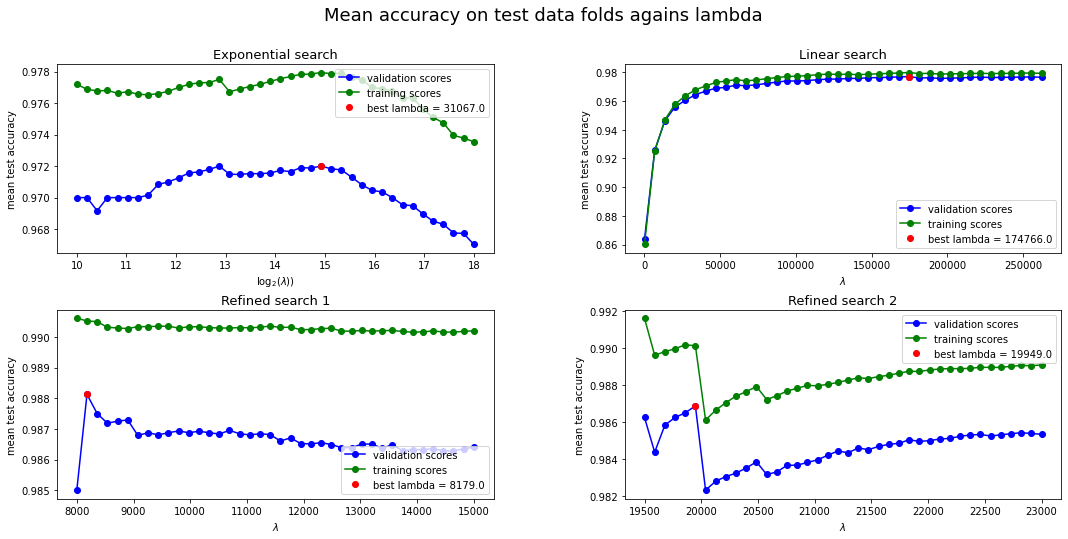

In [116]:
best_lambd_index_exp_bal = int(np.where(lambd_range_exp==best_lambd_exp_bal)[0])
best_lambd_index_lin_bal = int(np.where(lambd_range_lin==best_lambd_lin_bal)[0])
best_lambd_index_ref_bal = int(np.where(lambd_range_ref==best_lambd_ref_bal)[0])
best_lambd_index_ref_1_bal = int(np.where(lambd_range_ref_1==best_lambd_ref_1_bal)[0])

plt.figure(figsize=(18, 8))
plt.subplot(2, 2, 1)
plt.plot(np.log2(lambd_range_exp), mean_val_scores_exp_bal, marker = 'o', color = "b", label= "validation scores")
plt.plot(np.log2(lambd_range_exp), mean_train_scores_exp_bal, marker ='o', color = "g", label= "training scores")
plt.plot(np.log2(lambd_range_exp[best_lambd_index_exp_bal]), mean_val_scores_exp_bal[best_lambd_index_exp_bal], 
         'ro', label=f"best lambda = {np.round(best_lambd_exp_bal)}")
plt.xlabel("$\log_2(\lambda))$")
plt.ylabel("mean test accuracy")
plt.title("Exponential search", fontsize=13)
plt.legend(loc="upper right")

plt.subplot(2, 2, 2)
plt.plot(lambd_range_lin, mean_val_scores_lin_bal, marker = 'o', color = "b", label= "validation scores")
plt.plot(lambd_range_lin, mean_train_scores_lin_bal, marker ='o', color = "g", label= "training scores")
plt.plot(lambd_range_lin[best_lambd_index_lin_bal], mean_val_scores_lin_bal[best_lambd_index_lin_bal], 
         'ro', label=f"best lambda = {np.round(best_lambd_lin_bal)}")
plt.xlabel("$\lambda$")
plt.ylabel("mean test accuracy")
plt.title("Linear search", fontsize=13)
plt.legend(loc="lower right")

plt.subplot(2, 2, 3)
plt.plot(lambd_range_ref, mean_val_scores_ref_bal, marker = 'o', color = "b", label= "validation scores")
plt.plot(lambd_range_ref, mean_train_scores_ref_bal, marker ='o', color = "g", label= "training scores")
plt.plot(lambd_range_ref[best_lambd_index_ref_bal], mean_val_scores_ref_bal[best_lambd_index_ref_bal], 
         'ro', label=f"best lambda = {np.round(best_lambd_ref_bal)}")
plt.xlabel("$\lambda$")
plt.ylabel("mean test accuracy")
plt.title("Refined search 1", fontsize=13)
plt.legend(loc="lower right")

plt.subplot(2, 2, 4)
plt.plot(lambd_range_ref_1, mean_val_scores_ref_1_bal, marker = 'o', color = "b", label= "validation scores")
plt.plot(lambd_range_ref_1, mean_train_scores_ref_1_bal, marker ='o', color = "g", label= "training scores")
plt.plot(lambd_range_ref_1[best_lambd_index_ref_1_bal], mean_val_scores_ref_1_bal[best_lambd_index_ref_1_bal], 
         'ro', label=f"best lambda = {np.round(best_lambd_ref_1_bal)}")
plt.xlabel("$\lambda$")
plt.ylabel("mean test accuracy")
plt.title("Refined search 2", fontsize=13)
plt.legend(loc="upper right")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
plt.suptitle("Mean accuracy on test data folds agains lambda", fontsize=18)

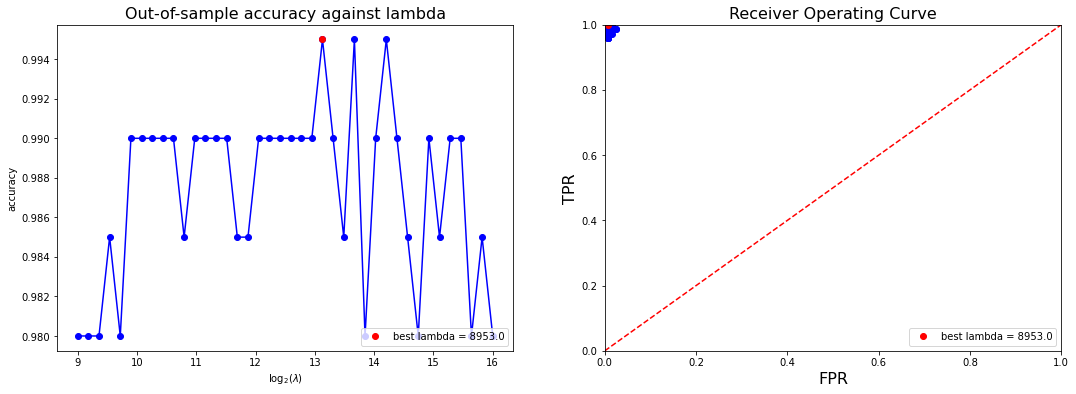

In [118]:
plot_folds(X_train_bal, y_train_bal, X_test, y_test, 1, lambd_range=[2**i for i in np.linspace(9, 16, 40)],
           all_lambd_w = all_lambd_weights_exp_bal)  # exponential range

Looking at the results from training on the balanced dataset, we again see oscillatory behaviour. The refined searches have shown that the optimal hyperparameter is around 8000 based on the cross-validation. Comparing to the test data, the range seems correct, although subsequent refinements could be done in order to confirm this. Training on the balanced dataset gave lower $\lambda$ values and slightly higher test accuracies than training on the imbalanced dataset. The former observation could be due to having more malignant datapoints. Separating few malignant points by a hyperplane is much easier, hence we do not need a large width. Thus it makes sense that the balanced dataset needs a larger width, thus a lower hardness hyperparameter.

When comparing the results of training on the balanced and imbalanced datasets, one should first note that the balanced training dataset is around a third the size of the imbalanced training dataset. Although balancedness is a strength, the small size is a weekness in the training. Hence there is a trade-off between these two features, and one should not automatically choose to train on a balanced dataset. If the imbalanced data is much bigger, corrections can be done using over- and undersampling techniques. However, in our case, the ROC curves show a clear favour for the balanced dataset.

Finally, one should not that the above analysis is not conclusive due to the encountered oscillatory behaviour and dependence on the iterations. As mentioned, averaging over iterations of the cross-validation could supply more confidence in the optimality of the obtained hardness parameters.